In [1]:
# %load ./scripts/do_RT_thermal.py
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
import sys
#sys.path.append('../')
from models import *

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import met_brewer as mb
colors = {}
ccmap = {}
colors['hiro'] = mb.met_brew(name="Hiroshige",brew_type='continuous')
ccmap['hiro'] = LinearSegmentedColormap.from_list('temp', colors['hiro'][::-1], N=100)
register_cmap(cmap=ccmap['hiro'])
colors['dust'] = mb.met_brew(name="Cassatt1",brew_type='continuous')
ccmap['dust'] = LinearSegmentedColormap.from_list('dust', colors['dust'], N=100)
register_cmap(cmap=ccmap['dust'])
colors['gas'] = mb.met_brew(name="Hokusai2",brew_type='continuous')
ccmap['gas'] = LinearSegmentedColormap.from_list('gas', colors['gas'], N=50)
register_cmap(cmap=ccmap['gas'])
colors['vel'] = mb.met_brew(name="Troy",brew_type='continuous')
ccmap['vel'] = LinearSegmentedColormap.from_list('vel', colors['vel'], N=50)
register_cmap(cmap=ccmap['vel'])

In [3]:
gma = {'gm2a': {'snapshot':20},'gm2b':{'Min':5e-7,'snapshot':40},'gm2c':{'Min':1e-7,'snapshot':20},
      'gm1a':{'snapshot':10,'Mdisk':0.1,'Mfrac':[0.001,0.006]},'gm1b':{'snapshot':20,'Mdisk':0.1,'Min':5e-7,'Mfrac':[0.001,0.006]},'gm1c':{'snapshot':10,'Mdisk':0.1,'Min':1e-7,'Mfrac':[0.001,0.006]},
       'gm05a':{'snapshot':10,'Mdisk':0.05,'Mfrac':[0.002,0.012]},'gm05b':{'snapshot':15,'Mdisk':0.05,'Min':5e-7,'Mfrac':[0.002,0.012]},'gm05c':{'snapshot':50,'Mdisk':0.05,'Min':1e-7,'Mfrac':[0.002,0.012]},
       'gm02a':{'snapshot':10,'Mdisk':0.02,'Mfrac':[0.005,0.03]},'gm02b':{'snapshot':100,'Mdisk':0.02,'Min':5e-7,'Mfrac':[0.005,0.03]},'gm02c':{'snapshot':20,'Mdisk':0.02,'Min':1e-7,'Mfrac':[0.005,0.03]}}

In [4]:
parentsim = '/home/akuznetsova/fargo_infall/outputs/'
dir_names = ['02a','02b','02c','05a','05b','05c','1a','1b','1c','2a','2b','2c']
mods_env = {}
mods_nak = {}
for dn in dir_names:
    simdir = 'gm'+dn
    outdir = 'out/gmaur/'+simdir
    mods_env[dn] = load_model(outdir=outdir+'/')
    mods_nak[dn] = load_model(outdir=outdir+'_noenv/')
    run_nak = mods_nak[dn]
    run = mods_env[dn]
    run.read_rho()
    run.read_Tdust()
    run.calc_Jint()
    print('env run ' + dn + 'done')
    run_nak.read_rho()
    run_nak.read_Tdust()
    run_nak.calc_Jint()
    print('disk run ' + dn + 'done')
    print('-----------------------')
    #disk_from_fargo(run.m,parentsim+simdir+'/',snapshot=gma['gm'+dn]['snapshot'],fluid=0)
    #run_nak.m.disk['hydro'] = run.m.disk['hydro']

directory exists - will overwrite current model if you write to it!
Loading from model directory:/home/akuznetsova/wedgeford/out/gmaur/gm02a/
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/wavelength_micron.inp
directory exists - will overwrite current model if you write to it!
Loading from model directory:/home/akuznetsova/wedgeford/out/gmaur/gm02a_noenv/
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a_noenv/wavelength_micron.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/gas_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/dust_temperature.dat
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/mcmono_wavelength_micron.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a/mcmono_wavelength_micron.inp
env run 02adone
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm02a_noenv/gas_density.inp
Reading /home/akuzn

FileNotFoundError: [Errno 2] No such file or directory: '/home/akuznetsova/wedgeford/out/gmaur/gm2__noenv/'

In [110]:
#mods_nak['2_'] = load_model(outdir='out/gmaur/gm2_/')

run = mods_nak['2_']
run.read_rho()
run.read_Tdust()
run.calc_Jint()

Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/gas_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/dust_temperature.dat
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/mcmono_wavelength_micron.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/mcmono_wavelength_micron.inp


True

In [1298]:
def dev_ave(self, time, prop, dim=None):
    ave = self.get(time,prop,dim=1)
    dev = self.get(time,prop) - self.make_2d(ave)
    if dim == 1:
        return np.average(dev, axis=1)
    else:
        return dev
        
def alpha_rey(self,time,dim=None):
    cs = self.sound_speed()
    sig = self.get(time,'sigma')
    num = sig*dev_ave(self,time,'vphi')*dev_ave(self,time,'vr')
    den = sig*cs**2
    alpha = num/den
    if dim == 0:
        return np.abs(np.average(num)/np.average(den))
    elif dim == 1:
        return np.abs(np.average(num, axis=1)/np.average(den,axis=1))
    else:
        return alpha
    
    
def vorticity(disk,time):
    R,PHI = np.meshgrid(disk.r,disk.phi)
    vphi = dev_ave(disk,time,prop='vphi',dim=None)*(yr/AU)
    vr = disk.get(time,prop='vr',dim=None)*(yr/AU)
    vorticity =   np.gradient(vphi,disk.r,axis=0)  - (np.gradient(vr,disk.phi,axis=1)/R.T) 
    return vorticity


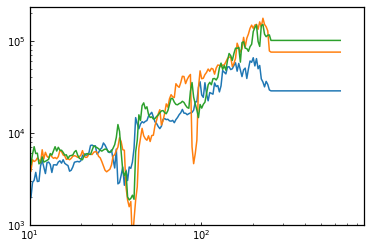

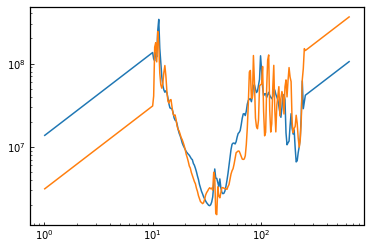

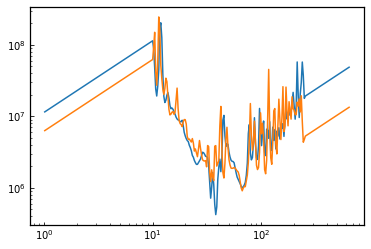

In [1305]:
def tau_in(key):
    run = mods_env[key]
    Md = run.m.disk['Mdisk']
    Min = run.m.env['Min']
    tau_in = (0.1*Md)/Min
    return tau_in

def tau_ff(key,rout=600):
    run = mods_env[key]
    tau = (1/np.sqrt(2))*(rout/run.m.r)**(3/2) * tau_orb(run.m.r)
    #loglog(run.m.r, tau)
    return tau

def sim_data(key):
    simdir = '/home/akuznetsova/fargo_infall/outputs/gm'+key+'/'
    disk = fargo_disk(simdir,Mstar=1.1)
    return disk

def alpha(key):
    disk = sim_data(key)
    time = gma['gm'+key]['snapshot']
    alpha = uniform_filter1d(alpha_rey(disk,time=time,dim=1),size=10)
    alpha = np.interp(run.m.r,disk.r,alpha)
    return alpha

def Ro_num(key):
    disk = sim_data(key)
    time = gma['gm'+key]['snapshot']
    w = np.abs((np.amin(vorticity(disk,time),axis=1)))
    Ross = uniform_filter1d(w,size=4)
    Ross = np.interp(run.m.r,disk.r,Ross)*tau_orb(run.m.r)/(4*pi)
    loglog(run.m.r,(1/Ross)*tau_orb(run.m.r))
    return Ross
    
    
def tau_diff(key):
    run = mods_env[key]
    alpha_ = alpha(key)
    tau = (0.01/alpha_)*(run.m.r/run.m.H(run.m.r))**2 * tau_orb(run.m.r)
    #loglog(run.m.r,tau)
    return tau
    
def tau_obs(key):
    run = mods_env[key]
    #loglog(run.m.r,tau_in(key)+tau_ff(key))
    return tau_in(key) + tau_ff(key)

def tau_st_mm(key):
    run = mods_env[key]
    rhos = run.m.dust['rho_si']
    sigma = (np.average(run.rho['gas'].swapaxes(0,1),axis=-1)[-1,:])*np.sqrt(pi)*run.m.H(run.m.r)*AU
    a = 1e-3 #mm
    St = (pi/2)*rhos*a/sigma
    tau = (1/St)*tau_orb(run.m.r)
    #loglog(run.m.r, tau)
    return tau
    
def tau_orb(r,M=1.1):
    return r**(3/2)*np.sqrt(M)
    
#tau_diff_list = [tau_diff(key) for key in mods_env.keys()]
#tau_obs_list = np.array([tau_obs(key) for key in mods_env.keys()])
#tau_st_list = [tau_st_mm(key) for key in mods_env.keys()]

run = mods_env['2a']

Ro_num('2c')
Ro_num('02c')
Ro_num('1c')

xlim(10,)
ylim(1e3,)
show()
loglog(run.m.r, tau_diff('02a'))
loglog(run.m.r, tau_diff('02b'))
show()
loglog(run.m.r, tau_diff('05a'))
loglog(run.m.r, tau_diff('05b'))

In [24]:
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter1d

In [1091]:
def csrot(crd=None, ang=None, deg=True):
    """ Performs coordinate system rotation.
    Parameters
    ----------
    crd : numpy ndarray
          Three element vector containing the coordinates of a given point in a cartesian system

    ang : list, ndarray
          Three element list/ndarray describing the rotation angles around the x, y and z axes, respectively
    
    deg : float, optional 
          If True angles should be given in degree instead of radians (as by default)


    Returns
    -------
    list
        Returns a three element list with the rotated coordinate

    """

    if ang is not None:
        xang = ang[0]
        yang = ang[1]
        zang = ang[2]
        
    if deg:
        xang = xang / 180.0 * np.pi
        yang = yang / 180.0 * np.pi
        zang = zang / 180.0 * np.pi
    
    dumx = np.cos(yang)*np.cos(zang)*crd[0] - (np.sin(zang)*np.cos(xang) 
            + np.sin(xang)*np.sin(yang)*np.cos(zang))
    
    if xang != 0.0:
        dumx = crd[0]
        dumy = np.cos(xang) * crd[1] - np.sin(xang) * crd[2]
        dumz = np.sin(xang) * crd[1] + np.cos(xang) * crd[2]

        crd = [dumx, dumy, dumz]
    
    if yang != 0.0:
        dumx = np.cos(yang) * crd[0] + np.sin(yang) * crd[2]
        dumy = crd[1]
        dumz = -np.sin(yang) * crd[0] + np.cos(yang) * crd[2]

        crd =  [dumx, dumy, dumz]

    if zang != 0.0:
        dumx = np.cos(zang) * crd[0] - np.sin(zang) * crd[1] + 0.0
        dumy = np.sin(zang) * crd[0] + np.cos(zang) * crd[1] + 0.0
        dumz = crd[2]

        crd = [dumx, dumy, dumz]

    return crd


In [1114]:
(90)**(3/2)*np.sqrt(1.9)

1176.9027147559818

[3000.         2068.96551724 1327.43362832 1167.3151751  1060.07067138]
Reading image.out


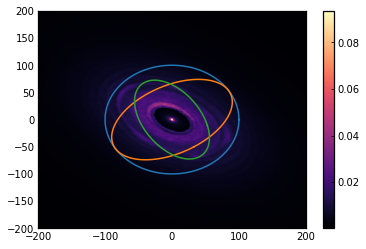

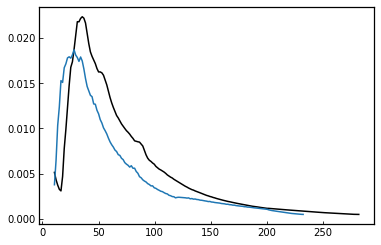

In [1112]:
gma_params = {'incl': 53.21, 'pa':57.17, 'dpc':159, 'dpc_err': 4}

def make_contimage(mu,sizeau=400,npix=400,params={}):
    if params == {}:
        incl = 0
        pa = 0
    else:
        incl = params['incl']
        pa = params['pa']
    command = 'radmc3d image npix {} sizeau {} incl {} lambda {} posang {} nphot_scat 1000000 setthreads 64'.format(npix,sizeau,incl,mu,pa)
    os.system(command)
    
def snu_units(image,dpc,fwhm =None,ifreq=0):
    dum_image = image
    data_im = np.squeeze(dum_image.image[:, ::-1, ifreq].T)
    data = data_im.copy()
    pixel_area = (dum_image.sizepix_x * dum_image.sizepix_y)/(dpc * pc)**2 * (180./np.pi*3600.)**2
    #beam_area = image.fwhm[0] * image.fwhm[1] * np.pi / 4. / np.log(2.0)
    data *= (dum_image.sizepix_x * dum_image.sizepix_y / (dpc * pc)**2. * 1e23)
    # Convert data to mJy/beam
    if fwhm is not None:
        beam_area = fwhm[0] * fwhm[1] * np.pi / 4. / np.log(2.0)
        data *= beam_area/ pixel_area
    data *= 1e3
    x = dum_image.x / AU #/ dpc
    y = dum_image.y / AU #/ dpc
    return x,y,data

def plot_ic_half(run,cmap,ax,vmin,vmax):
    os.chdir(run.m.outdir)
    im = rpy.image.readImage()
    fwhm_au= (12,12)
    fwhm = np.array(fwhm_au)/159.
    imc = im.imConv(dpc=159.,fwhm=fwhm,pa=0.0)
    x,y,data= snu_units(imc,159,fwhm,ifreq=0)
    half = int(len(x)/2)
    toplot = data
    imm = ax.pcolormesh(x[half:],y,toplot[:,:half][::-1,::-1],cmap=cmap,vmin=vmin,vmax=vmax,rasterized=True,shading='auto')
    return imm



class obs:
    def __init__(self,output,params):
        self.par = params
        self.dir = output.m.outdir
        self.I = {}
        self.Ic = {}
        if 'dpc' in params.keys():
            self.dpc = params['dpc']
        
    def make_contimage(self,mu,sizeau=400,npix=400,incl=0,pa=0):
        os.chdir(self.dir)
        write_main(run.m, scat=1,nphot=100000,mrw=1,maxtau=5)
        if 'incl' in self.par.keys() and incl is None:
            incl = self.par['incl']
        if 'pa' in self.par.keys() and pa is None:
            pa = self.par['pa']
        command = 'radmc3d image npix {} sizeau {} incl {} lambda {} posang {} nphot_scat 1000000 setthreads 64'.format(npix,sizeau,incl,mu,pa)
        os.system(command)   
    
    def read(self,key='1.3'):
        os.chdir(self.dir)
        im=rpy.image.readImage(binary=False)
        self.freq = im.freq
        self.nfreq = im.nfreq
        self.nx = im.nx
        self.ny = im.ny
        self.y = im.y/AU
        self.x = im.x/AU
        self.I[key] = im
        
    def project_coords(self,x,y,incl=None,pa=None):
        if 'incl' in self.par.keys() and incl is None:
            incl = self.par['incl']
        if 'pa' in self.par.keys() and pa is None:
            pa = self.par['pa']
        crds = csrot(np.array([x,y,np.zeros_like(x)]),[0,-incl,-pa])
        return crds[0],crds[1]
        
        
    def plot_im_basic(self,I,fwhm=None,**pkw):
        x,y,data = snu_units(I,self.dpc,fwhm=fwhm,ifreq=0)
        im = pcolormesh(x,y,data.T,**pkw)
        return im 
    
    def convolve(self,key_in,key_out=None,beam_au=[10,10],fwhm=None,pa=0):
        if fwhm is None:
            fwhm = np.array(beam_au)/self.dpc
            self.fwhm = fwhm
        else:
            self.fwhm = fwhm
        if key_out is None:
            key_out = key_in
        self.Ic[key_out] = self.I[key_in].imConv(fwhm=fwhm,pa=pa, dpc=self.dpc)
        
    def bin_radial(self,I,fwhm=None,nbin=100,incl=None,pa=None,rmin=10,rmax=300,stat='mean'):
        x,y,Idata = snu_units(I,self.dpc,fwhm=fwhm,ifreq=0)
        X,Y = np.meshgrid(x,y)
        Xr,Yr = self.project_coords(X,Y,incl=incl,pa=pa)
        rdata = np.sqrt(Xr**2 + Yr**2)
        rbin_e = np.linspace(rmin,rmax,nbin)
        rbin = 0.5*(rbin_e[1:] + rbin_e[:-1])
        I_r = stats.binned_statistic(rdata.flatten(),Idata.flatten(),bins=rbin_e,statistic=stat)[0]
        return rbin, I_r
    
        
    def plot_im_radial(self,I,fwhm=None,nbin=100,incl=None,pa=None,rmin=10,rmax=400,stat='mean',relmax=False,**pkw):
        rbin, I_r = self.bin_radial(I,fwhm=fwhm,nbin=nbin,incl=incl,pa=pa,rmin=rmin,rmax=rmax,stat=stat)
        if relmax==True:
            Imax = np.nanmax(I_r)
            plot(rbin,I_r/Imax,**pkw)
        else:
            plot(rbin,I_r, **pkw)
        
dn = '2a'

nu_list = np.array([100,145,226,257,283])*1e9
#wavelength of observations in microns
mu_list = 1e4*(3e10/(nu_list))
print(mu_list)
#fwhm of observations in arcseconds
fwhm_list = np.array([[295,210],[57,35],[130,94],[117,83],[270,162]])*1e-3
#pa of beam in degrees
pa_list = np.array([5.7,-13.8,9.1,-1.5,0.1])
# noise in mJansky/beam
noise_list =np.array([12.4,11.3,16.7,21.9,57.6])*1e-3

obs_params = {'nu': nu_list, 'wav':mu_list, 'fwhm':fwhm_list, 'pa':pa_list,'noise':noise_list}

o1 = obs(mods_env[dn],gma_params)
o1.read(key='1.3')

o1.convolve(key_in='1.3',fwhm=[0.013,0.0094],pa=pa_list[2])


im = o1.plot_im_basic(o1.Ic['1.3'],fwhm = o1.fwhm,cmap='magma')
colorbar(im)
th = np.linspace(0,2*pi,100)
xc = 100*np.cos(th)
yc = 100*np.sin(th)
plot(xc,yc)
xci,yci = o1.project_coords(xc,yc,incl=gma_params['incl'],pa=gma_params['pa'])
plot(xci,yci)
xce,yce = o1.project_coords(xci,yci,incl=-gma_params['incl'],pa=-gma_params['pa'])
plot(xce,yce)
show()
r, Imean = o1.bin_radial(o1.Ic['1.3'],nbin=200,incl=0,pa=0,fwhm=o1.fwhm,rmin=10)
r, Imean2 = o1.bin_radial(o1.Ic['1.3'],nbin=200,fwhm=o1.fwhm,rmin=10)


plot(r,Imean,color='black')
plot(r,Imean2)
show()



In [1095]:
for key in ['2a']:
    print(key)
    run = mods_env[key]
    os.chdir(run.m.outdir)
    write_main(run.m, scat=1,nphot=100000,mrw=1,maxtau=5)
    make_contimage(mu=1326,params=gma_params)
    print('done!')

2a
updating radmc3d.inp
done!


## Continuum Density + Emission

Reading /home/akuznetsova/wedgeford/out/gmaur/gm2a_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2a_noenv/gas_density.inp


<ipython-input-447-a5e994aaeab3>:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im=a.pcolormesh(X,Y,toplot,cmap=cmap,vmin=-2,vmax=2,rasterized=True)


Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2b_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2b_noenv/gas_density.inp
Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2c_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2c_noenv/gas_density.inp
Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1a_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1a_noenv/gas_density.inp
Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1b_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1b_noenv/gas_density.inp
Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1c_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm1c_noenv/gas_density.inp
Reading image.out
Reading /home/akuznetsova/wedgeford/out/gmaur/gm05a_noenv/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm05a_noenv/gas_density.inp
Reading 

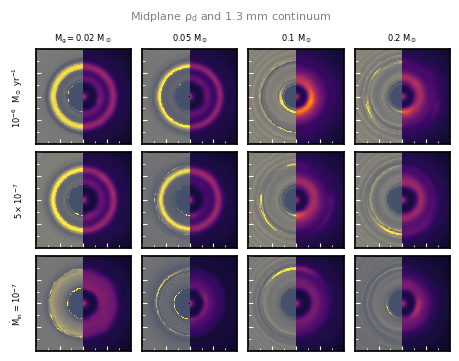

In [447]:
m_d = ['2','1','05','02']
m_in = ['a','b','c']
min_d = {'a':1e-6,'b':5e-7,'c':1e-7}
ls = {'a':'solid','b':'dashed','c':'dotted'}
m = {'a':'o','b':'^','c':'+'}
lw = {'2': 2, '1': 1, '05':0.5,'02': 0.2}
colors = {'2':'navy','1':'C0','02':'skyblue'}
cmap = 'cividis'

f,ax = subplots(3,4,constrained_layout=True,dpi=100)
f.set_size_inches(4.5,3.5)

run0 = mods_nak['gm2_']

for diskmass, aa in zip(m_d,[ax[:,3],ax[:,2],ax[:,1],ax[:,0]]):
    for infall,a in zip(m_in,aa):
        run = mods_nak[diskmass + infall]
        R,TH,PHI = run.m.make_grid()
        X = (R*np.cos(PHI))[-1,:,:]
        Y = (R*np.sin(PHI))[-1,:,:]
        #pl0_d = (run0.rho['dust1'] + run0.rho['dust2'])[:,-1,:]
        pl0_d = (run.m.rho_midplane(R[-1,:,:],fluid=1) + run.m.rho_midplane(R[-1,:,:],fluid=2))
        rho_mid_d = (run.rho['dust1'] + run.rho['dust2'])[:,-1,:]
        toplot = rho_mid_d/pl0_d - 1.
        im=a.pcolormesh(X,Y,toplot,cmap=cmap,vmin=-2,vmax=2,rasterized=True)
        imm = plot_ic_half(run,'inferno',a,vmin=-0.1,vmax=1.8)
        a.axis('scaled')
        a.set_xlim(-120,120)
        a.set_ylim(-120,120)
        a.set_facecolor('black')
        a.xaxis.set_major_formatter(NullFormatter())
        a.yaxis.set_major_formatter(NullFormatter())
        a.xaxis.set_major_locator(MultipleLocator(60))
        a.yaxis.set_major_locator(MultipleLocator(60))
        a.xaxis.set_minor_locator(MultipleLocator(30))
        a.yaxis.set_minor_locator(MultipleLocator(30))
        a.tick_params(colors='white', which='both',labelcolor='black',labelsize=8)
        
ax[0,3].set_title(r'$ 0.2 \ {\rm M_\odot}$',fontsize=6)
ax[0,2].set_title(r'$ 0.1 \ {\rm M_\odot}$',fontsize=6)
ax[0,1].set_title(r'$ 0.05 \ {\rm M_\odot}$',fontsize=6)
ax[0,0].set_title(r'$M_{\rm g} = 0.02 \ {\rm M_\odot}$',fontsize=6)

ax[0,0].set_ylabel(r'$10^{-6} \ \ {\rm M_\odot \ yr^{-1}}$',fontsize=6)
ax[1,0].set_ylabel(r'$5 \times 10^{-7} $',fontsize=6)
ax[2,0].set_ylabel(r'$\dot{M}_{\rm in} = 10^{-7}$',fontsize=6)

f.suptitle(r'Midplane $\rho_{\rm d}$ and 1.3 mm continuum',color='gray',fontsize=8)
fig_path = '/home/akuznetsova/wedgeford/out/gmaur/'
#f.savefig(fig_path+'dustcont.png',dpi=300)

Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/dust_density.inp
Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/gas_density.inp


<ipython-input-448-fc2575644df8>:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im=a.pcolormesh(X,Y,toplot,cmap=cmap,vmin=-2,vmax=2,rasterized=True)


Reading image.out


Text(60, 102.0, '1.3 mm')

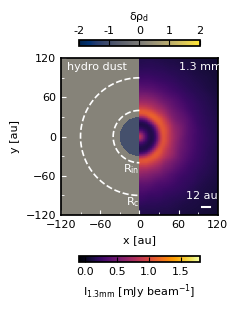

In [448]:
f,a = subplots(1,constrained_layout=True,dpi=100)
f.set_size_inches((2.25,3.))
run = mods_nak['2_']
R,TH,PHI = run.m.make_grid()
X = (R*np.cos(PHI))[-1,:,:]
Y = (R*np.sin(PHI))[-1,:,:]
rin=40
rc = 90
phic = np.linspace(pi/2, 3*pi/2, 100)
cmap = 'cividis'
pl0_d = (run.m.rho_midplane(R[-1,:,:],fluid=1) + run.m.rho_midplane(R[-1,:,:],fluid=2))

rho_mid_d = (run.rho['dust1'] + run.rho['dust2'])[:,-1,:]
toplot = rho_mid_d/pl0_d - 1.

im=a.pcolormesh(X,Y,toplot,cmap=cmap,vmin=-2,vmax=2,rasterized=True)
imm = plot_ic_half(run,'inferno',a,vmin=-0.1,vmax=1.8)

a.axis('scaled')
a.set_xlim(-120,120)
a.set_ylim(-120,120)
#a.set_facecolor('black')
a.plot(rin*np.cos(phic),rin*np.sin(phic),lw=1.2,color='white',ls='dashed')
a.plot(rc*np.cos(phic),rc*np.sin(phic),lw=1.2,color='white',ls='dashed')
a.xaxis.set_major_locator(MultipleLocator(60))
a.yaxis.set_major_locator(MultipleLocator(60))
a.xaxis.set_minor_locator(MultipleLocator(30))
a.yaxis.set_minor_locator(MultipleLocator(30))
a.plot(np.linspace(0.8,0.9,50)*120, np.ones(50)*-120*0.9,color='white')
a.text(0.6*120,0.8*-120,'12 au',color='white',fontsize=8)
a.text(-25,-55,r'$R_{\rm in}$', fontsize=8,color='white')
a.text(-20,-105,r'$R_{\rm c}$', fontsize=8,color='white')

a.tick_params(colors='white', which='both',labelcolor='black',labelsize=8)
cb = colorbar(im,ax=a,location='top',shrink=0.75)
cb2 = colorbar(imm,ax=a,location='bottom',shrink=0.75)
cb2.set_label(label=r'$I_{\rm 1.3 mm} \ \mathrm{[mJy \ beam^{-1}]}$',size=8)
cb.set_label(label=r'$\delta \rho_{\rm d}}$',size=8)
cb.set_ticks([-2,-1,0,1,2])
cb2.set_ticks([0,0.5,1,1.5])
cb.set_ticklabels(cb.get_ticks().astype(str),size=8)
cb2.set_ticklabels(cb2.get_ticks().astype(str),size=8)
a.set_xlabel('x [au]',size=8)
a.set_ylabel('y [au]',size=8)

a.text(-110,120*0.85, 'hydro dust',color='white',size=8)
a.text(60,120*0.85, '1.3 mm',color='white',size=8)
#f.savefig(fig_path+'dustcont_0.png',dpi=300)

In [84]:
def make_subplot(rows,cols,xlabel='',ylabel=''):
    nrows = len(rows)
    ncols = len(cols)
    f, ax = subplots(nrows,ncols,constrained_layout=True,dpi=200)
    f.set_size_inches(ncols*1,nrows*1)
    if ncols > 1 and nrows > 1:
        a_cols = [ax[:,i] for i in range(ncols)]
        a_rows = [ax[i,:] for i in range(nrows)]
        for a in a_cols[1:]:
            for aa in a:
                aa.yaxis.set_major_formatter(NullFormatter())
        for a in a_rows[:-1]:
            for aa in a:
                aa.xaxis.set_major_formatter(NullFormatter())
        for a in a_rows[-1]:
            a.set_xlabel(xlabel)
        for a in a_cols[0]:
            a.set_ylabel(ylabel)
        return f, (a_rows,a_cols)
    elif ncols > 1 and nrows == 1:
        a_cols = ax
        for a in a_cols[1:]:
            a.yaxis.set_major_formatter(NullFormatter())
        a_cols[0].set_ylabel(ylabel)
        return f, a_cols
    elif nrows > 1 and ncols == 1:
        a_rows = ax
        for a in a_rows[:-1]:
            a.xaxis.set_major_formatter(NullFormatter())
        a_rows[-1].set_xlabel(xlabel)
        return f, a_rows

## Temperature Structure

In [13]:
def plot_temp_contour(run,levels,ax=None,axj=None,gas=True,fill=True,ratio=False):
    if ax is None:
        ax = gca()
    if axj is None:
        a = ax
    else:
        a = ax[axj]
    R,Z = run.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    if ratio == False:
        zaxis = zcyl
    else:
        zaxis = zcyl/rcyl
    nH = np.log10(2*run.calc_rho2D('gas').T/(mu*mh))
    if gas == True:
        toplot = np.clip(run.calc_T2D('gas').T,a_min=levels[0],a_max=levels[-1])
        toplot[nH < 0] = None
        if fill == True:
            im = a.contourf(rcyl,zaxis,toplot,cmap='temp',levels=levels)
        else:
            levels = levels[::2][:6]
            im = a.contour(rcyl,zaxis,toplot,colors='black',levels=levels,linewidths = 1)
            a.clabel(im,im.levels,fontsize=6, inline_spacing=10)
    else:
        toplot = np.clip(run.calc_T2D('dust').T,a_min=levels[0],a_max=levels[-1])
        toplot[nH < 0] = None
        if fill == True:
            im = a.contourf(rcyl,zaxis,toplot,cmap='temp',levels=levels)
        else:
            levels = levels[::2][:6]
            im = a.contour(rcyl,zaxis,toplot,colors='black',levels=levels,linewidths = 1)
            a.clabel(im,im.levels,fontsize=6,inline_spacing=10)
    a.set_xlim(10,300)
    
    a.xaxis.set_major_locator(MultipleLocator(100))
    a.xaxis.set_minor_locator(MultipleLocator(25))
    if ratio == False:
        a.set_ylim(0,150)
        a.yaxis.set_major_locator(MultipleLocator(25))
        a.yaxis.set_minor_locator(MultipleLocator(5))
    else:
        a.set_ylim(0,1)
        a.yaxis.set_major_locator(MultipleLocator(0.1))
        a.yaxis.set_minor_locator(MultipleLocator(0.01))
    return im

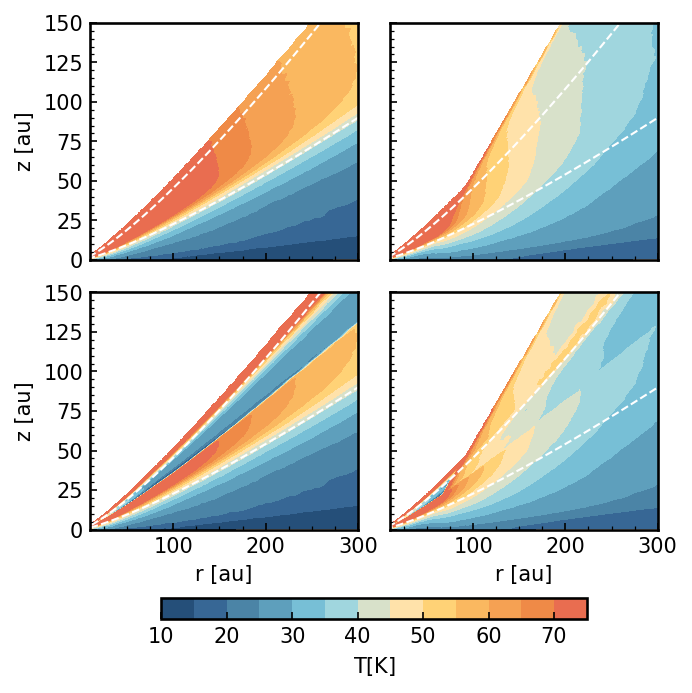

In [22]:
m_d = ['2','1','05','02']
m_in = ['a','b','c']
min_d = {'a':1e-6,'b':5e-7,'c':1e-7}
ls = {'a':'solid','b':'dashed','c':'dotted'}
m = {'a':'o','b':'^','c':'+'}
lw = {'2': 2, '1': 1, '05':0.5,'02': 0.2}
colors = {'2':'navy','1':'C0','02':'skyblue'}
f,(ax1,ax2) = subplots(2,2,sharey = 'row', sharex='col',constrained_layout=True,dpi=150)
f.set_size_inches(4.5,4.5)

levels = np.arange(10,80,5)
H_levels = [0,3,6]
dn = '2a'
run_e = mods_env[dn]
run_n = mods_nak[dn]
r_cyl,z_cyl = run_n.m.make_rz()
r_cyl = r_cyl[:,:,0]
z_cyl = z_cyl[:,:,0]
for run,a1,a2 in zip([run_n,run_e],ax1,ax2):
    im = plot_temp_contour(run,levels=levels,ax=a1,axj=None,gas= False)
    im2 = plot_temp_contour(run,levels=levels,ax=a2,axj=None,gas= True)
    H_arr = run.m.H(r_cyl)
    a1.contour(r_cyl,z_cyl,z_cyl/H_arr,levels=H_levels,colors='white',linestyles='dashed',linewidths=1)
    a2.contour(r_cyl,z_cyl,z_cyl/H_arr,levels=H_levels,colors='white',linestyles='dashed',linewidths=1)

cb = colorbar(im,ax=ax2,location='bottom',extend='both',shrink=0.75)
cb.set_label(label=r'${\rm T [K]}$',fontsize=10)
for a in ax2:
    a.set_xlabel('r [au]',fontsize=10)
for a in [ax1[0],ax2[0]]:
    a.set_ylabel('z [au]',fontsize=10)

Text(0.5, 0.98, '$T_{\\rm gas}$ with vertical layer')

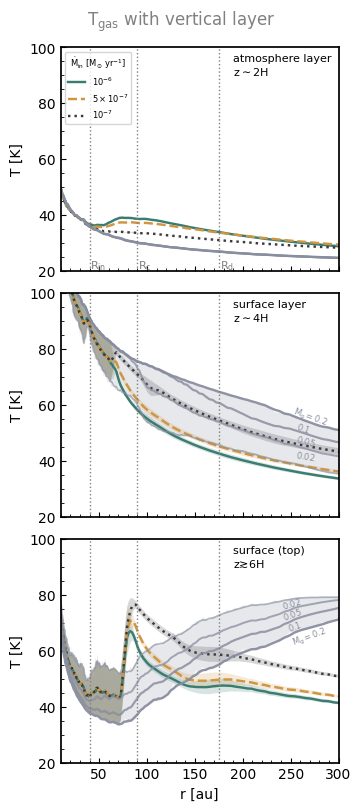

In [34]:
from scipy import stats
def get_layer_T(run,zmin=1,zmax=3,gas=True):
    if gas == True:
        Tarr = run.calc_T2D('gas').T
        rhoarr = run.calc_rho2D('gas').T
    else:
        Tarr = run.calc_T2D('dust').T
        rhoarr = run.calc_rho2D('dust').T
    R,Z = run.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    Hvals = run.m.H(rcyl)
    zindex = np.where((zcyl >= zmin*Hvals) & (zcyl <= zmax*Hvals))
    rvals = rcyl[zindex]
    rindex = np.argsort(rvals)
    zvals = zcyl[zindex][rindex]
    Tvals = Tarr[zindex][rindex]
    rhovals = rhoarr[zindex][rindex]
    rvals = rvals[rindex]
    T_ = stats.binned_statistic(rvals,Tvals,bins=run.m.coords[0],statistic='mean')[0]
    return T_

def plot_surf_T(zmin=3,zmax=6,ax=None):
    m_d = ['2','1','05','02']
    ls = ['solid','dashed','dotted']
    labels = [r'$10^{-6}$',r'$5\times 10^{-7}$',r'$10^{-7}$']
    infall_colors = ["#3b7c70", "#ce9642", "#3b3a3e","#898e9f"]
    if ax is None:
        ax = gca()
    else:
        sca(ax)
    
    for infall,lls,lab,cc in zip(['a','b','c'],ls,labels,infall_colors):
        rn1 = '02'+infall
        rn2 = '2' + infall
        run1 = mods_env[rn1]
        run2 = mods_env[rn2]
        l1 = uniform_filter1d(get_layer_T(run1,zmin=zmin,zmax=zmax,gas=True),size=4)
        l2 = uniform_filter1d(get_layer_T(run2,zmin=zmin,zmax=zmax,gas=True),size=4)
        ax.fill_between(run1.m.r,l1,l2,color=cc,ls=lls,alpha=0.2,lw=0)
        ax.plot(run1.m.r, 0.5*(l1+l2),color=cc,ls=lls,lw=1.75,label=lab)
    run1 = mods_nak[rn1]
    run2 = mods_nak[rn2]
    l1 = get_layer_T(run1,zmin=zmin,zmax=zmax,gas=True)
    l2 = get_layer_T(run2,zmin=zmin,zmax=zmax,gas=True)
    ax.fill_between(run1.m.r,l1,l2,color=infall_colors[-1],ls=lls,alpha=0.2,lw=0,zorder=0)
    for diskmass, lw,alpha in zip(m_d[::-1],np.linspace(1.25,1.75,4),np.linspace(0.65,0.95,4)):
        run = mods_nak[diskmass+'a']
        l1 = uniform_filter1d(get_layer_T(run,zmin=zmin,zmax=zmax,gas=True),size=4)
        ax.plot(run1.m.r, l1,color=infall_colors[-1],ls='solid',lw=lw,alpha=alpha)
    ax.set_xlim(10,300)
    ax.set_ylim(20,100)

infall_colors = ["#3b7c70", "#ce9642", "#3b3a3e","#898e9f"]
f,ax = subplots(3,constrained_layout=True,dpi=100)
f.set_size_inches(3.5,8)
for a,zb in zip(ax,[[1.5,2.5],[3.5,4.5],[5.5,6.5]]):
    plot_surf_T(zmin=zb[0],zmax=zb[1],ax=a)
    if a != ax[-1]:
        a.xaxis.set_major_formatter(NullFormatter())
    a.set_ylabel('T [K]',fontsize=10)
    a.xaxis.set_major_locator(MultipleLocator(50))
    a.xaxis.set_minor_locator(MultipleLocator(10))
    a.yaxis.set_major_locator(MultipleLocator(20))
    a.yaxis.set_minor_locator(MultipleLocator(5))
    a.axvline(40,ls='dotted',lw=1,color='gray')
    a.axvline(90,ls='dotted',lw=1,color='gray')
    a.axvline(175,ls='dotted',lw=1,color='gray')
    
legend = ax[0].legend(loc=2,title=r'$\dot{M}_{\rm in} \ \mathrm{[M_{\odot} \ yr^{-1}]}$',fontsize=6)
legend.get_title().set_fontsize('6')
ax[0].text(190,95,r'atmosphere layer',fontsize=8)
ax[0].text(190,90,r'$z \sim 2H $',fontsize=8)
ax[1].text(190,95,r'surface layer',fontsize=8)
ax[1].text(190,90,r'$z \sim 4H $',fontsize=8)
ax[2].text(190,95,r'surface (top)',fontsize=8)
ax[2].text(190,90,r'$z \gtrsim 6H $',fontsize=8)

ax[0].text(41,21,r'$R_{\rm in}$',color='gray',fontsize=8)
ax[0].text(91,21,r'$R_{\rm c}$',color='gray',fontsize=8)
ax[0].text(176,21,r'$R_{\rm d}$',color='gray',fontsize=8)

ax[1].text(250,53, r'$M_{\rm g} = 0.2 $',color=infall_colors[-1],fontsize=6,rotation=-20)
ax[1].text(255,50, r'$0.1$',color=infall_colors[-1],fontsize=6,rotation=-20)
ax[1].text(255,45, r'$0.05$',color=infall_colors[-1],fontsize=6,rotation=-15)
ax[1].text(255,40, r'$0.02$',color=infall_colors[-1],fontsize=6,rotation=-10)
ax[2].text(250,62, r'$M_{\rm g} = 0.2 $',color=infall_colors[-1],fontsize=6,rotation=20)
ax[2].text(245,67, r'$0.1$',color=infall_colors[-1],fontsize=6,rotation=20)
ax[2].text(240,71, r'$0.05 $',color=infall_colors[-1],fontsize=6,rotation=20)
ax[2].text(240,75, r'$0.02 $',color=infall_colors[-1],fontsize=6,rotation=17)
        
ax[-1].set_xlabel('r [au]',fontsize=10)
f.suptitle(r'$T_{\rm gas}$ with vertical layer',fontsize=12,color='gray')

In [28]:
def get_midplane_temp(run):
    from scipy import stats
    R,Z = run.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    Hval = run.m.H(run.m.r,fluid=2)
    zindex = (zcyl < Hval)
    Tvals = run.calc_T2D('dust').T
    Tmid = Tvals[zindex]
    rvals = rcyl[zindex]
    rindex = np.argsort(rvals)
    rvals = rvals[rindex]
    Tmid = Tmid[rindex]
    T_ = stats.binned_statistic(rvals,Tmid,bins=run.m.coords[0],statistic='mean')
    return T_[0]

def get_midplane_density(run):
    from scipy import stats
    R,Z = run.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    Hval = run.m.H(run.m.r,fluid=2)
    zindex = (zcyl < Hval)
    rhovals = run.calc_rho2D('dust').T
    rhomid = rhovals[zindex]
    rvals = rcyl[zindex]
    rindex = np.argsort(rvals)
    rvals = rvals[rindex]
    rhomid = rhomid[rindex]
    rho_ = stats.binned_statistic(rvals,rhomid,bins=run.m.coords[0],statistic='mean')
    return rho_[0]

def get_rcav(run):
    rho_ = get_midplane_density(run)
    r_search = (run.m.r < 50) & (run.m.r > 30)
    min_i = np.argmin(rho_[r_search])
    return run.m.r[r_search][min_i]

#colors = ['skyblue','C0','teal','navy']
colors = ['#8C2F39','#F0BCD4','#1B9AAA','#0A2342']

#c_env = '#283220'
#c_nak = '#8BA776'
c_env = 'black'
c_nak = 'gray'
        
def plot_Tmid(rn,ax,ls,color='navy',env=True):
    if env == True:
        Tme = get_midplane_temp(mods_env[rn])
        Tenv = uniform_filter1d(Tme,size=2)
        ax.semilogx(run.m.r, Tenv,color=color,ls=lls,lw=1.25)
    else:
        Tm_nak = get_midplane_temp(mods_nak[rn])
        Tnak = uniform_filter1d(Tm_nak,size=2)
        ax.semilogx(run.m.r, Tnak,color=color,ls=lls,lw=1.25)
    ax.set_xlim(10,600)
    ax.set_ylim(5,30)
    
def plot_rhomid(rn,ax,ls,color='navy',env=True):
    if env == True:
        Tme = get_midplane_density(mods_env[rn])
        Tenv = uniform_filter1d(Tme,size=2)
        ax.semilogy(run.m.r, Tenv,color=color,ls=lls,lw=1.25)
    else:
        Tm_nak = get_midplane_density(mods_nak[rn])
        Tnak = uniform_filter1d(Tm_nak,size=2)
        ax.semilogy(run.m.r, Tnak,color=color,ls=lls,lw=1.25)
    #ax.set_xlim(10,600)
    #ax.set_ylim(5,30)

Reading /home/akuznetsova/wedgeford/out/gmaur/gm2_/dust_temperature.dat


Text(0.5, 0.98, '$T_{\\rm dust}$ [Midplane]')

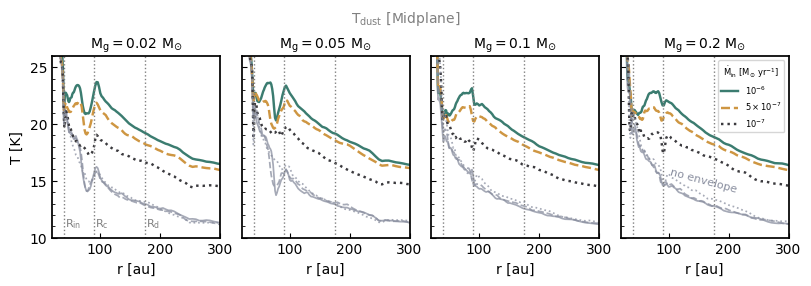

In [29]:
f,ax = subplots(1,4,constrained_layout=True,dpi=100)
f.set_size_inches(8,2.75)
Tm_0 = uniform_filter1d(get_midplane_temp(mods_nak['2_']),size=2)
m_d = ['2','1','05','02']
#m_d = ['2','1','05']#,'02']
ls = ['solid','dashed','dotted']
labels = [r'$10^{-6}$',r'$5\times 10^{-7}$',r'$10^{-7}$']
for infall,lls,lab,cc in zip(['a','b','c'],ls,labels,infall_colors):
    for diskmass,a in zip(m_d[::-1],ax):
        rn = diskmass + infall
        Tme = get_midplane_temp(mods_env[rn])
        Tm_nak = get_midplane_temp(mods_nak[rn])
        toplot1 = uniform_filter1d(Tm_nak,size=2)
        toplot2 = uniform_filter1d(Tme,size=2)
        a.plot(run.m.r, toplot2, ls= lls,color=cc,lw=1.75,label=lab)
        a.plot(run.m.r, toplot1, ls= lls,color=infall_colors[-1],lw=1.25,alpha=0.75)     
        a.set_xlim(20,300)
        a.set_ylim(10,26)
        #a.set_xscale('log')
        if a != ax[0]:
            a.yaxis.set_major_formatter(NullFormatter())
        else:
            a.set_ylabel('T [K]',fontsize=10)
        
        a.yaxis.set_major_locator(MultipleLocator(5))
        a.yaxis.set_minor_locator(MultipleLocator(1))
        #a.xaxis.set_major_locator(MultipleLocator(50))
        #a.xaxis.set_minor_locator(MultipleLocator(10))
        
for a in ax:
    #a.plot(run.m.r, Tm_0, ls= 'solid',color='gray',lw=1)
    a.axvline(40,color='gray',ls='dotted',lw=1)
    a.axvline(90,color='gray',ls='dotted',lw=1)
    a.axvline(175,color='gray',ls='dotted',lw=1)
    a.set_xlabel('r [au]',fontsize=10)
    
ax[0].text(41,11,r'$R_{\rm in}$',color='gray',fontsize=8)
ax[0].text(91,11,r'$R_{\rm c}$',color='gray',fontsize=8)
ax[0].text(176,11,r'$R_{\rm d}$',color='gray',fontsize=8)

ax[0].set_title(r'$M_{\rm g} = 0.02 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[1].set_title(r'$M_{\rm g} = 0.05 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[2].set_title(r'$M_{\rm g} = 0.1 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[3].set_title(r'$M_{\rm g} = 0.2 \ \mathrm{M_{\odot}}$',fontsize=10)

legend = ax[-1].legend(title=r'$\dot{M}_{\rm in} \ \mathrm{[M_{\odot} \ yr^{-1}]}$',fontsize=6)
ax[-1].text(100,14,'no envelope',color=infall_colors[-1],fontsize=8,rotation=-15)
legend.get_title().set_fontsize('6')
f.suptitle(r'$T_{\rm dust}$ [Midplane]',fontsize=10,color='gray')
#f.savefig(fig_path+'Tmid_0.png',dpi=300)

Text(0.5, 0.98, 'Perturbations to $T_{\\rm dust}$ [midplane]')

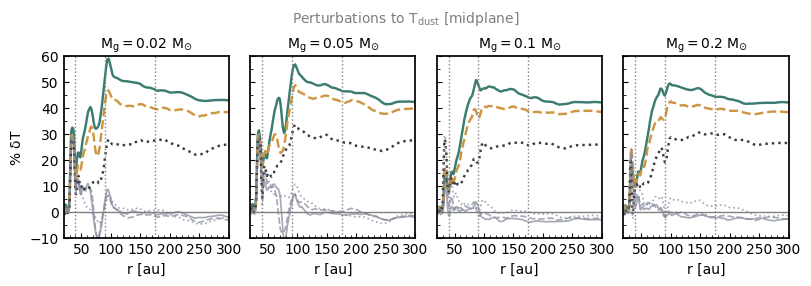

In [30]:
m_d = ['2','1','05','02']
f,ax = subplots(1,4,constrained_layout=True,dpi=100)
f.set_size_inches(8,2.75)
ls = ['solid','dashed','dotted']
Tm_0 = uniform_filter1d(get_midplane_temp(mods_nak['2_']),size=2)
for infall,lls,lab,cc in zip(['a','b','c'],ls,labels,infall_colors):
    for diskmass,a in zip(m_d[::-1],ax):
        rn = diskmass + infall
        Tme = get_midplane_temp(mods_env[rn])
        Tm_nak = get_midplane_temp(mods_nak[rn])
        toplot1 = uniform_filter1d(Tme/Tm_0 -1.,size=4)*100
        toplot2 = uniform_filter1d(Tm_nak/Tm_0 -1.,size=4)*100
        #a.fill_between(run.m.r, toplot2, toplot1, color=cc, alpha=0.3,ls=lls)
        #a.fill_between(run.m.r, np.zeros_like(toplot2), toplot2, color=cc, alpha=0.3,ls=lls,lw=0)
        a.plot(run.m.r, toplot1, ls = lls,color=cc,label=lab,lw=1.75)
        a.plot(run.m.r, toplot2, ls= lls,color=infall_colors[-1],lw=1.25,alpha=0.75)        
        a.set_xlim(20,300)
        a.set_ylim(-10,60)
        if a != ax[0]:
            a.yaxis.set_major_formatter(NullFormatter())
        else:
            a.set_ylabel(r'$\% \ \delta T$',fontsize=10)
        a.yaxis.set_major_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(5))
        a.xaxis.set_major_locator(MultipleLocator(50))
        a.xaxis.set_minor_locator(MultipleLocator(10))
        
#ax[0].text(40,45,r'$R_{\rm in}$',color='gray',fontsize=8)
#ax[0].text(90,45,r'$R_{\rm c}$',color='gray',fontsize=8)
#ax[0].text(175,45,r'$R_{\rm d}$',color='gray',fontsize=8)
#ax.set_ylim(10,40)
for a in ax:
    a.axvline(40,color='gray',ls='dotted',lw=1)
    a.axvline(90,color='gray',ls='dotted',lw=1)
    a.axvline(175,color='gray',ls='dotted',lw=1)
    a.axhline(0,color='gray',ls='solid',lw=1)
    a.set_xlabel('r [au]',fontsize=10)
ax[0].set_title(r'$M_{\rm g} = 0.02 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[1].set_title(r'$M_{\rm g} = 0.05 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[2].set_title(r'$M_{\rm g} = 0.1 \ \mathrm{M_{\odot}}$',fontsize=10)
ax[3].set_title(r'$M_{\rm g} = 0.2 \ \mathrm{M_{\odot}}$',fontsize=10)

f.suptitle(r'Perturbations to $T_{\rm dust}$ [midplane]',fontsize=10,color='gray')
#f.savefig(fig_path+'Tmid_1.png',dpi=300)

In [429]:
from scipy import stats
from scipy import integrate
file_prefix = '/home/akuznetsova/wedgeford/out/gmaur/GM_Aur_'
file_list = ['C18O','13CO','CO']
file_end = '_Setup1B6_FullTemp.txt'
layer_list = ['mid','warm','upper']
dpc = 159.
abund_list = [1, 557/69,557]
nr = 50
rbin_e = np.linspace(30,400,nr+1)
rbin = (rbin_e[1:] + rbin_e[:-1])*0.5
dr = np.diff(rbin_e)

layers={}
for j,k,a in zip(file_list,layer_list,abund_list):
    r,z,T = np.loadtxt(file_prefix+j+file_end,skiprows=1,unpack=True,delimiter=',')
    layers[k] = {'rau':r*dpc,'zau':z*dpc, 'T':T}
    layers[k]['Tbin'],be,bn = stats.binned_statistic(layers[k]['rau'],layers[k]['T'],bins=rbin_e,statistic='mean')
    layers[k]['Tsig'],be,bn = stats.binned_statistic(layers[k]['rau'],layers[k]['T'],bins=rbin_e,statistic='std')
    layers[k]['zbin'],be,bn = stats.binned_statistic(layers[k]['rau'],layers[k]['zau'],bins=rbin_e,statistic='mean')
    layers[k]['zsig'],be,bn = stats.binned_statistic(layers[k]['rau'],layers[k]['zau'],bins=rbin_e,statistic='std')
    layers[k]['dfac'] = a
    

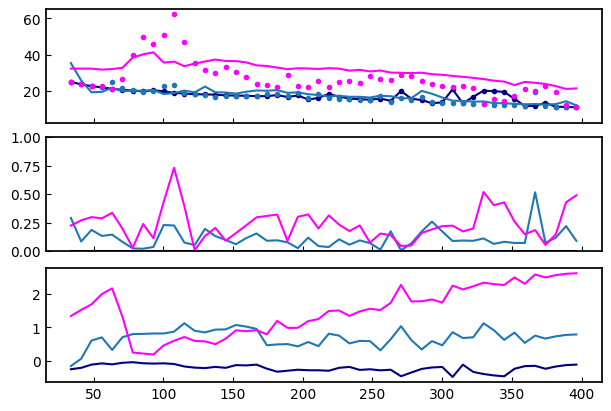

In [562]:
from scipy import interpolate, ndimage
def model_Tstruct(run,layers):
    def calc_tau(Ts,Tb):
        return -np.log(1.-Tb/Ts)
    R,Z = run.m.make_rz()
    rcyl2d = R[:,:,0].flatten()
    zcyl2d = Z[:,:,0].flatten()
    rcyl = R.flatten()
    zcyl = Z.flatten()
    Tf = 20.0
    nH = (2*run.rho['gas']/(mu*mh)).swapaxes(0,1)
    nG0 = np.log10(4*pi*run.J['uv']['J_phot']*run.J['uv']['e_phot']/G0).swapaxes(0,1)
    if 'gas' not in run.T.keys():
        run.calc_Tgas(ndim=3)
    Tg = run.T['gas'].swapaxes(0,1)
    nH[(np.log10(nH)-nG0 > -6)] *= 1e-8
    nH[(Tg < Tf) & (np.log10(nH) - nG0 < -7)] *= 8e-5
    
    rbin_e = np.linspace(30,400,nr+1)
    rbin = (rbin_e[1:] + rbin_e[:-1])*0.5
    dr = np.diff(rbin_e)
    
    def extract_surface_T(rbins,z,zwidth):
        zint = np.expand_dims(np.interp(run.m.r,rbins,z),axis=(0,2))
        zwint = np.expand_dims(np.interp(run.m.r,rbins,zwidth),axis=(0,2))
        zindex = np.where(np.abs(Z - zint)/zwint <= 3)
        rvals = R[zindex]
        rindex = np.argsort(rvals)
        zvals = Z[zindex][rindex]
        Tvals = Tg[zindex][rindex]
        nvals = nH[zindex][rindex]
        rvals = rvals[rindex]
        T_n = stats.binned_statistic(rvals,Tvals*(nvals**2),bins=rbin_e,statistic='mean')[0]
        n_ = stats.binned_statistic(rvals,nvals**2,bins=rbin_e,statistic='mean')[0]
        T_ = T_n/n_
        T_ = np.interp(rbins,rbins[T_>0],T_[T_>0])
        Tvar = stats.binned_statistic(rvals,Tvals,bins=rbin_e,statistic='std')[0]
        return T_, Tvar
    
    def n_col_surface(rbins,z,zwidth):
        def nbin():
            rmin, rmax = 32, 400
            zmin, zmax = 1e-1, 400
            nr = 120
            nz = 120
            rbin_e = np.logspace(np.log10(rmin),np.log10(rmax),nr+1)
            rbin = (rbin_e[1:] + rbin_e[:-1])*0.5
            #zbin_e = np.logspace(np.log10(zmin),np.log10(zmax),nz+1)
            zbin_e = np.linspace(zmin,zmax,nz+1)
            zbin = (zbin_e[1:] + zbin_e[:-1])*0.5
            rbg, zbg = np.meshgrid(rbin,zbin)
            rbg = rbg.T
            zbg = zbg.T
            dz = np.diff(zbin_e*AU)
            dr = np.diff(rbin_e*AU)

            n_binned = stats.binned_statistic_2d(rcyl,zcyl,nH.flatten(),bins=[rbin_e,zbin_e],statistic='mean')[0]

            n_binned[np.isnan(n_binned) &  (zbg > 5)] = np.amin(n_binned[~np.isnan(n_binned)])
            for j in np.arange(nr):
                ncol = n_binned[j,:]
                new_ncol = np.interp(zbin,zbin[ncol > 0],ncol[ncol>0])
                n_binned[j,:] = new_ncol
                n_col = np.flip(np.cumsum(np.flip(n_binned*dz,axis=1),axis=1),axis=1)
            return rbg,zbg, n_col
        rbg, zbg, n_col = nbin()
        zint = np.expand_dims(np.interp(np.unique(rbg),rbins,z),axis=-1)
        zwint = np.expand_dims(np.interp(np.unique(rbg),rbins,zwidth),axis=-1)
        zindex = np.where(np.abs(zbg - zint)/zwint <= 3)
        zvals = zbg[zindex]
        rvals = rbg[zindex]
        n_col_vals = n_col[zindex]
        n_col_bin = np.clip(stats.binned_statistic(rvals,n_col_vals,bins=rbin_e,statistic='mean')[0],a_min = 5e21,a_max=None)
        n_col_bin = np.interp(rbins,rbins[n_col_bin > 0], n_col_bin[n_col_bin >0])
        return n_col_bin

    
    co_21 = {}
    l1 = layers['mid']
    l2 = layers['warm']
    l3 = layers['upper']
    co_21['mid'] = {}
    co_21['warm'] = {}
    co_21['upper'] = {}
    

        
    def layer_iter0(co_layer,ll,tau_fac=None): 
        zvals_ = ll['zbin']
        rvals = rbin
        zsig_ = ll['zsig']
        Tvals_ = ll['Tbin']
        Tsig_ = ll['Tsig']
        
        
        zvals = np.interp(rvals,rvals[zvals_>0],zvals_[zvals_>0])
        zsig = np.interp(rvals,rvals[zsig_>0],zsig_[zsig_>0])
        Tvals = np.interp(rvals,rvals[Tvals_>0],Tvals_[Tvals_>0])
        Tsig = np.interp(rvals,rvals[Tsig_>0],Tsig_[Tsig_>0])
        Tsig[Tsig_<=0] = Tvals[Tsig_<=0]*0.2
        Ts_lay, Tsig_lay = extract_surface_T(rvals,zvals,zsig)
        ncol_lay = n_col_surface(rvals,zvals,zsig)
        
        if tau_fac is not None:
            tau_lay = np.clip(ncol_lay*tau_fac,a_min=0.6,a_max=None)
            #print(tau_lay)
        else:
            tau_lay = np.clip(calc_tau(Ts_lay,Tvals),a_min=1e-2,a_max=None)
            tau_fac = tau_lay/ncol_lay
        
        #plot(rvals,np.log10(tau_lay),'.')
        #ylim(-2,5)
        #show()
        Tb_lay = Ts_lay*(1.- np.exp(-tau_lay))
        Ts_m_lay = Tvals/(1. - np.exp(-tau_lay))
        
        co_layer['r'] = rvals
        co_layer['z'] = zvals
        co_layer['Tb'] = Tvals
        co_layer['Tb_sig'] = Tsig
        co_layer['Ts'] = Ts_lay
        co_layer['tau'] = tau_lay
        co_layer['Ts_o'] = Ts_m_lay
        co_layer['Tb_m'] = Tb_lay
        co_layer['Ts_sig'] = Tsig_lay
        co_layer['tau_fac'] = tau_fac
        co_layer['residuals'] = (Tb_lay - Tvals)
        
        return co_layer
        
    
    co_21['mid'] = layer_iter0(co_21['mid'],l1)
    co_21['warm'] = layer_iter0(co_21['warm'],l2,tau_fac=co_21['mid']['tau_fac']*l2['dfac'])
    co_21['upper'] = layer_iter0(co_21['upper'],l3,tau_fac=co_21['mid']['tau_fac']*l3['dfac'])
    return co_21



        
run = mods_nak['2_']
run.co = model_Tstruct(run,layers)
colors = ['navy','C0','magenta']
labels = [r'$T_{\rm s} \mathrm{[K]} \ C^{18}O$', r'$T_{\rm s} \mathrm{[K]} \ ^{13}CO$', r'$T_{\rm s} \mathrm{[K]} \ ^{12}CO$']

keys = ['mid','warm','upper']

def plot_fit(run):
    f,ax = subplots(3,constrained_layout=True,sharex='col',dpi=100)
    for key,c in zip(keys,colors):
        Tmod = run.co[key]['Ts']
        Tobs = run.co[key]['Ts_o']
        tau = run.co[key]['tau']
        ax[0].plot(rbin,Tobs,color=c)
        ax[0].plot(rbin,Tmod,'.',color=c)
        ax[0].set_ylim(2,65)
        ax[1].plot(rbin,np.abs(run.co[key]['residuals'])/run.co[key]['Tb'],color=c)
        ax[1].set_ylim(0,1)
        ax[2].plot(rbin,np.log10(tau),color=c)
        
        
plot_fit(run)

In [590]:
def plot_grid(run_list,layer_keys,prop_key,**pkw):
    f,ax = subplots(len(run_list),constrained_layout=True,sharex='col',dpi=100)
    f.set_size_inches(2,len(run_list)*0.5)
    for run,a in zip(run_list,ax):
        for layer,ylim in zip(layer_keys,np.linspace(1,len(layer_keys),len(layer_keys))):
            rvals = run.co[layer]['r']
            prop = np.repeat(np.expand_dims(run.co[layer][prop_key],axis=1),3,axis=1)
            yaxis = np.linspace(ylim+1.1,ylim+2,3)
            #im=a.pcolormesh(rvals,yaxis,prop.T,**pkw)
            im=a.contourf(rvals,yaxis,prop.T,**pkw)
        a.yaxis.set_major_formatter(NullFormatter())
    cb = colorbar(im,ax=ax,location='bottom',extend='both')
    return f

def plot_grid_p(run_list,prop_key,**pkw):
    f,ax = subplots(1,len(run_list),constrained_layout=True,sharex='col',dpi=100)
    f.set_size_inches(len(run_list),1)
    for run,a in zip(run_list,ax):
        rvals = run.co['mid']['r']
        prop = np.repeat(np.expand_dims(run.co[prop_key],axis=1),3,axis=1)
        yaxis = np.linspace(0,2,3)
        #im=a.pcolormesh(rvals,yaxis,prop.T,**pkw)
        im=a.contourf(rvals,yaxis,prop.T,**pkw)
        a.yaxis.set_major_formatter(NullFormatter())
        a.xaxis.set_major_formatter(NullFormatter())
    #cb = colorbar(im,ax=ax,location='bottom',extend='both')
    return f


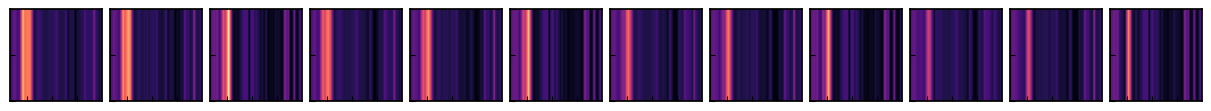

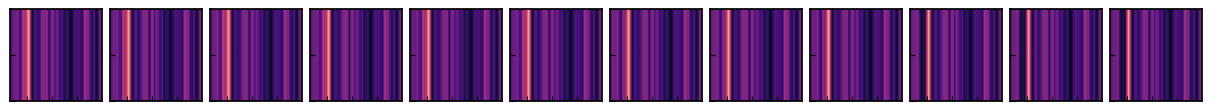

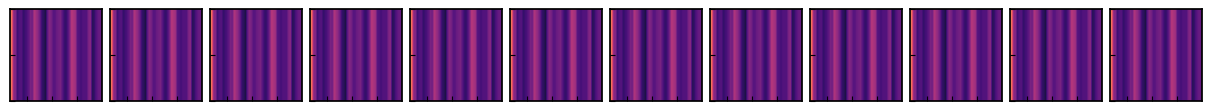

In [591]:
f = plot_grid_p(run_list1,'total_res',cmap='magma',levels=np.linspace(0,30,100))
f2 = plot_grid_p(run_list2,'total_res',cmap='magma',levels=np.linspace(0,30,100))
f3 = plot_grid_p(run_list1,'total_sig',cmap='magma',levels=np.linspace(0,10,100))

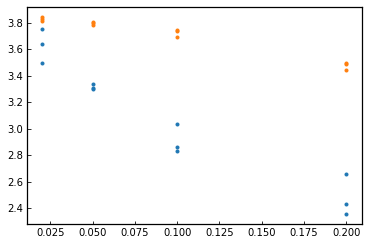

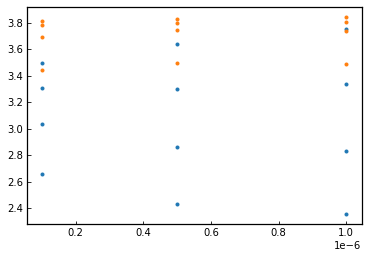

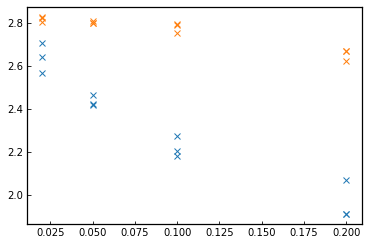

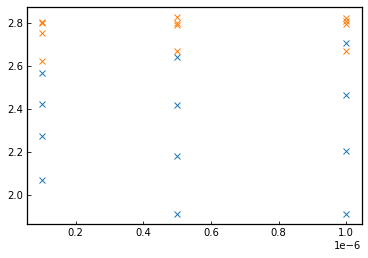

In [608]:
key_list = ['02a','02b','02c','05a','05b','05c','1a','1b','1c','2a','2b','2c']
run_list1 = [mods_env[key] for key in key_list]
run_list2 = [mods_nak[key] for key in key_list]
layer_keys = ['warm','upper']


Md_list = [run.m.disk['Mdisk'] for run in run_list1]
Min_list = [run.m.env['Min'] for run in run_list1]
res_list1 = [run.co['sum_res_rel'] for run in run_list1]
res_list2 = [run.co['sum_res_rel'] for run in run_list2]
res_list1_b = [run.co['sum_res']/run.co['sum_sig'] for run in run_list1]
res_list2_b = [run.co['sum_res']/run.co['sum_sig'] for run in run_list2]


plot(Md_list,res_list1,'.')
plot(Md_list,res_list2,'.')

show()

plot(Min_list,res_list1,'.')
plot(Min_list,res_list2,'.')
show()
plot(Md_list,res_list1_b,'x')
plot(Md_list,res_list2_b,'x')
show()
plot(Min_list,res_list1_b,'x')
plot(Min_list,res_list2_b,'x')


Text(0.5, 0.98, 'Effect of Envelope on inferred HD mass')

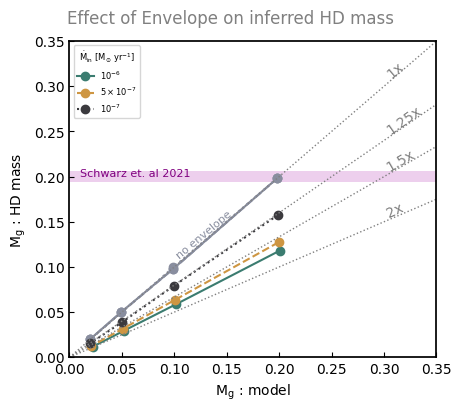

In [795]:
def F_ratio(run1, run2, plot=False):
    rho1 = run1.rho['gas']/(mu*mh)
    rho2 = run2.rho['gas']/(mu*mh)
    T1 = run1.T['gas']
    T2 = run2.T['gas']
    
    F1 = (rho1*np.exp(-128.5/T1))
    F2 = (rho2*np.exp(-128.5/T2))
    
    F1[(T1>50)] = None
    F2[(T2>50)] = None
    
    F1 = F1.swapaxes(0,1)
    F2 = F2.swapaxes(0,1)
    
    
    dv = run1.m.dvol()
    F_ratio = np.nansum(F1*dv)/np.nansum(F2*dv)
    if plot == True:
        R,Z = run1.m.make_rz()
        rcyl = R[:,:,0]
        zcyl = Z[:,:,0]
        pcolormesh(rcyl,zcyl,np.log10(np.nansum(F1*dv,axis=-1)),vmin=48,vmax=50)
        colorbar()
        show()

        pcolormesh(rcyl,zcyl,np.log10(np.nansum(F2*dv,axis=-1)),vmin=48,vmax=50)
        colorbar()
        show()

        pcolormesh(rcyl,zcyl,np.log10(np.nansum(F2,axis=-1)) - np.log10(np.nansum(F1,axis=-1)),vmin=-2,vmax=0.5,cmap='cubehelix_r')
        colorbar()
        show()
    return F_ratio

m_d = ['2','1','05','02']
m_in = ['a','b','c']
lls = ['solid','dashed','dotted']
labels = [r'$10^{-6}$',r'$5\times 10^{-7}$',r'$10^{-7}$']
f,ax= subplots(1,constrained_layout=True,dpi=100)
f.set_size_inches(4.5,4)
for infall,ls in zip(m_in,lls):
    diskmass0 = '2'
    rn0 = mods_nak[diskmass0 + infall]
    rn_list = [mods_nak[diskmass + infall] for diskmass in m_d]
    fratio_list = np.array([F_ratio(rn,rn0) for rn in rn_list])
    m1_list = np.array([M_tot(rn,'gas') for rn in rn_list])
    mobs_list = fratio_list*m1_list[0]
    dm_obs_list = m1_list - mobs_list
    ax.plot(m1_list,mobs_list,'o',color=infall_colors[-1],ls=ls)
    
#for infall,ls in zip(m_in,lls):
    #diskmass0 = '2'
    #rn0 = mods_env[diskmass0 + infall]
    #rn_list = [mods_env[diskmass + infall] for diskmass in m_d]
    #fratio_list = np.array([F_ratio(rn,rn0) for rn in rn_list])
    #m1_list = np.array([M_tot(rn,'gas') for rn in rn_list])
    #mobs_list = fratio_list*m1_list[0]
    #dm_obs_list = m1_list - mobs_list
    #plot(mobs,m1_list,color=infall_colors[-1],ls=ls)

for infall,cc,ls,lab in zip(m_in,infall_colors,lls,labels):
    rn1_list = [mods_nak[diskmass + infall] for diskmass in m_d]
    rn2_list = [mods_env[diskmass + infall] for diskmass in m_d]
    fratio_list = np.array([F_ratio(rn1,rn2) for rn1, rn2 in zip(rn1_list,rn2_list)])
    m1_list = np.array([M_tot(rn,'gas') for rn in rn1_list])
    m2_list = np.array([M_tot(rn,'gas') for rn in rn2_list])
    mobs_list = fratio_list*m2_list
    dm_list = m2_list - m1_list
    dm_obs_list = m2_list - mobs_list 
    ax.plot(m2_list, mobs_list,'o',color=cc,ls=ls,label=lab)
    #plot(m2_list, dm_list/m1_list, 'x',color=cc)
ax.set_xlabel(r'$M_{\rm g}$ : model',fontsize=10)
ax.set_ylabel(r'$M_{\rm g}$ : HD mass',fontsize=10)

ax.set_ylim(0,0.35)
ax.set_xlim(0,0.35)

ax.plot(np.linspace(0.00,0.35,100),np.linspace(0.00,0.35,100),ls='dotted',lw=1,color='gray')
ax.plot(np.linspace(0.00,0.35,100),0.5*np.linspace(0.00,0.35,100),ls='dotted',lw=1,color='gray')
ax.plot(np.linspace(0.00,0.35,100),(1/1.5)*np.linspace(0.00,0.35,100),ls='dotted',lw=1,color='gray')
ax.plot(np.linspace(0.00,0.35,100),(1/1.25)*np.linspace(0.00,0.35,100),ls='dotted',lw=1,color='gray')

ax.fill_between(np.linspace(0.00,0.35,100),np.ones(100)*0.2*(0.97), np.ones(100)*0.2*1.03,color='plum',lw=0,alpha=0.5)
ax.text(0.01,0.2,'Schwarz et. al 2021',color='purple',fontsize=8)
legend = ax.legend(title=r'$\dot{M}_{\rm in} \ \mathrm{[M_{\odot} \ yr^{-1}]}$',fontsize=6)
ax.text(0.1,0.11,'no envelope',color=infall_colors[-1],fontsize=8,rotation=40)
legend.get_title().set_fontsize('6')
ax.text(0.3,0.31,'1x',rotation=40,color='gray')
ax.text(0.3,0.31*(1/1.25),'1.25x',rotation=35,color='gray')
ax.text(0.3,0.31*(1/1.5),'1.5x',rotation=30,color='gray')
ax.text(0.3,0.31*(1/2),'2x',rotation=25,color='gray')
#axhline(0,color='gray',lw=1,ls='dotted')
f.suptitle('Effect of Envelope on inferred HD mass',color='gray',fontsize=12)
#yscale('symlog')
#xlim(0.01,0.2)
#ylim(0,0.6)
#ylim(0.005,0.2)
#ylim(0,-0.5)
#yscale('log')

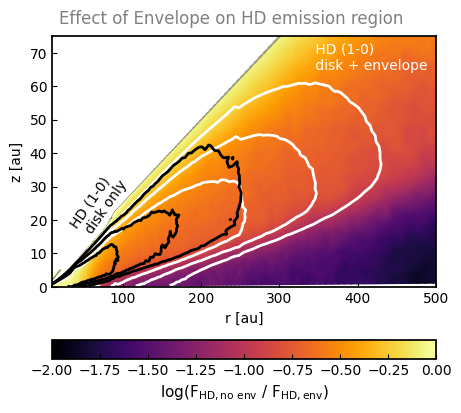

In [953]:
def F_plot(run1,run2):
    rho1 = run1.rho['gas']/(mu*mh)
    rho2 = run2.rho['gas']/(mu*mh)
    T1 = run1.T['gas']
    T2 = run2.T['gas']
    
    F1 = (rho1*np.exp(-128.5/T1))
    F2 = (rho2*np.exp(-128.5/T2))
    
    F1[(T1>50)] = None
    F2[(T2>50)] = None

    F1 = F1.swapaxes(0,1)
    F2 = F2.swapaxes(0,1)
    
    
    dv = run1.m.dvol()

  
    R,Z = run1.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    f,ax = subplots(1,constrained_layout=True,dpi=100)
    f.set_size_inches(4.5,4)
    F1_tot = np.log10(np.nansum(F1*dv))-np.log10(len(dv[~np.isnan(F1)])/len(run.m.phi)) 
    F2_tot = np.log10(np.nansum(F2*dv))-np.log10(len(dv[~np.isnan(F2)])/len(run.m.phi)) 
    levels= [-0.25,0,0.25]
    
    toplot1 = np.log10(np.nansum(F1*dv,axis=-1))-F1_tot
    toplot2 = np.log10(np.nansum(F2*dv,axis=-1))-F2_tot
    
    toplot3 = np.log10(np.nansum(F2,axis=-1)) - np.log10(np.nansum(F1,axis=-1))
    toplot3[zcyl/rcyl > 0.25] = None
    ax.contour(rcyl,zcyl,toplot1,levels=levels,colors='white',linestyles='solid',linewidths=2)
    ax.contour(rcyl,zcyl,toplot2,levels=levels,colors='black',linestyles='solid',linewidths=2)
    im = ax.pcolormesh(rcyl,zcyl,toplot3,vmin=-2,vmax=0,cmap='inferno',shading='gouraud',rasterized=True)
    ax.set_xlim(10,500)
    ax.set_ylim(0,75)
    ax.set_xlabel('r [au]',fontsize=10)
    ax.set_ylabel('z [au]', fontsize=10)
    colorbar(im,ax=ax,label=r'$\log ( F_{\rm HD, no \ env} \ / \ F_{\rm HD, env})$',location='bottom')
    ax.text(340,65, ' HD (1-0)  \n disk + envelope',color='white')
    ax.text(30,15, 'HD (1-0) \n disk only', color='black',rotation=55)
    #ax.set_facecolor('black')
    f.suptitle('Effect of Envelope on HD emission region',fontsize=12,color='gray')
run1 = mods_env['2a']
run2 = mods_nak['2a']
F_plot(run1,run2)

In [765]:
def M_tot(run,fluid,rcut=700):
    r,z = run.m.make_rz()
    rho = run.rho[fluid].swapaxes(0,1)[r<=rcut]
    dv = run.m.dvol()[r<=rcut]
    return 2*np.sum(rho*dv)/Msun

run1 = mods_nak['2a']
run2 = mods_env['2a']
Mg1 = M_tot(run1,'gas')
Md1 = M_tot(run1,'dust1') + M_tot(run1,'dust2')
Mg2 = M_tot(run2,'gas')
Md2 = M_tot(run2,'dust1') + M_tot(run2,'dust2')
Mg_e = Mg2-Mg1
Md_e = Md2-Md1

print(Mg_e/Mg2)
print(Md_e/Md2)

0.010718141846382001
0.029843920169238387


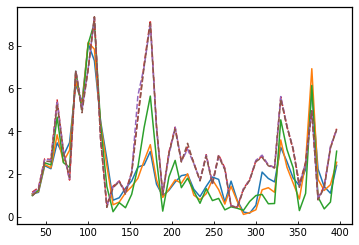

In [566]:
run_list = [mods_env['1a'],mods_env['1b'],mods_env['1c']]
run_list2 = [mods_nak['1a'],mods_nak['1b'],mods_nak['1c']]
layer_keys = ['warm','upper']
prop_key = 'residuals'

for run in run_list:
    #run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'])

for run in run_list2:
    #run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'],ls='dashed')


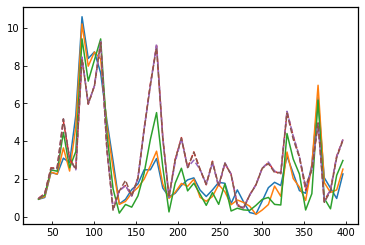

In [567]:
run_list = [mods_env['05a'],mods_env['05b'],mods_env['05c']]
run_list2 = [mods_nak['05a'],mods_nak['05b'],mods_nak['05c']]
layer_keys = ['warm','upper']
prop_key = 'residuals'

for run in run_list:
    #run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'])

for run in run_list2:
    #run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'],ls='dashed')


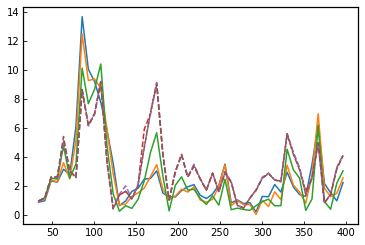

In [568]:
run_list = [mods_env['02a'],mods_env['02b'],mods_env['02c']]
run_list2 = [mods_nak['02a'],mods_nak['02b'],mods_nak['02c']]
layer_keys = ['warm','upper']
prop_key = 'residuals'

for run in run_list:
    run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'])

for run in run_list2:
    run.co = model_Tstruct(run,layers)
    run.co['total_res'] = np.sqrt(run.co['warm']['residuals']**2 + run.co['upper']['residuals']**2)
    run.co['total_sig'] = np.sqrt(run.co['warm']['Tb_sig']**2 + run.co['upper']['Tb_sig']**2)
    
    plot(rbin,run.co['total_res']/run.co['total_sig'],ls='dashed')


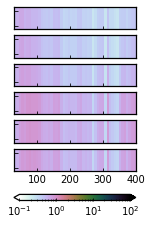

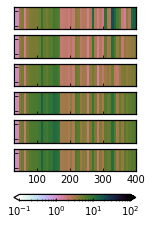

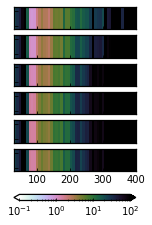

In [489]:
run_list = [mods_env['2a'],mods_env['2b'],mods_env['2c'],mods_nak['2a'],mods_nak['2b'],mods_nak['2c']]
layer_keys = ['mid']
prop_key = 'tau'

f1 = plot_grid(run_list,['mid'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))
f2 = plot_grid(run_list,['warm'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))
f3 = plot_grid(run_list,['upper'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))

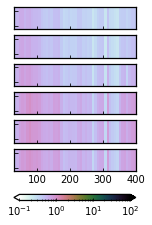

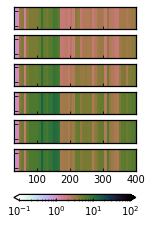

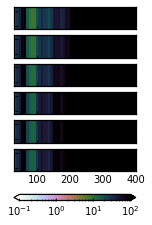

In [494]:
run_list = [mods_env['02a'],mods_env['02b'],mods_env['02c'],mods_nak['02a'],mods_nak['02b'],mods_nak['02c']]
layer_keys = ['mid']
prop_key = 'tau'

f1 = plot_grid(run_list,['mid'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))
f2 = plot_grid(run_list,['warm'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))
f3 = plot_grid(run_list,['upper'],prop_key,cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2))

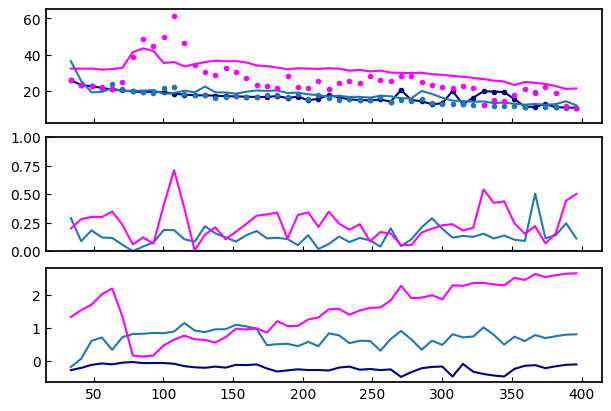

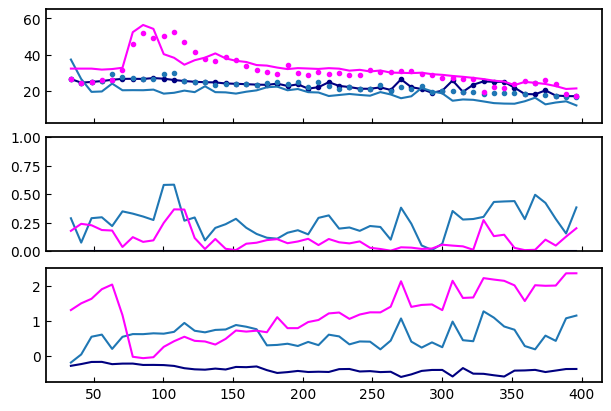

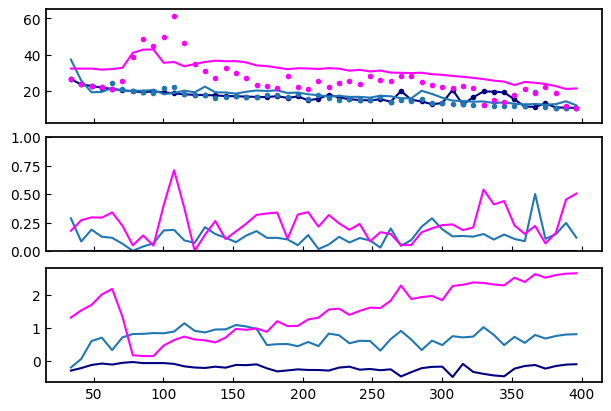

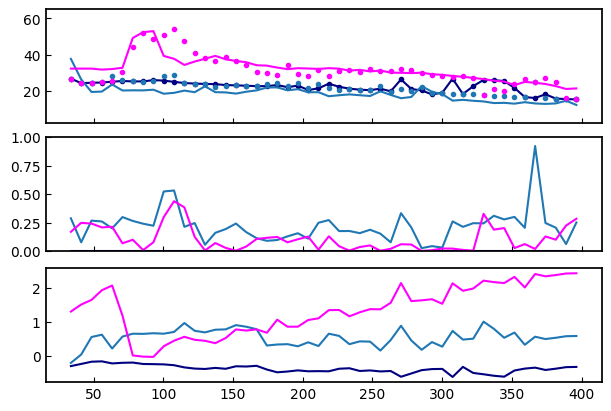

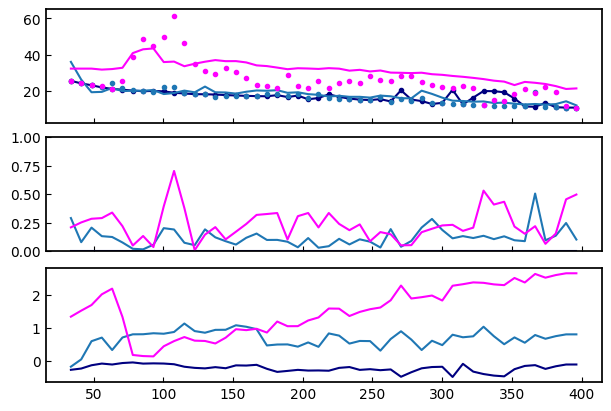

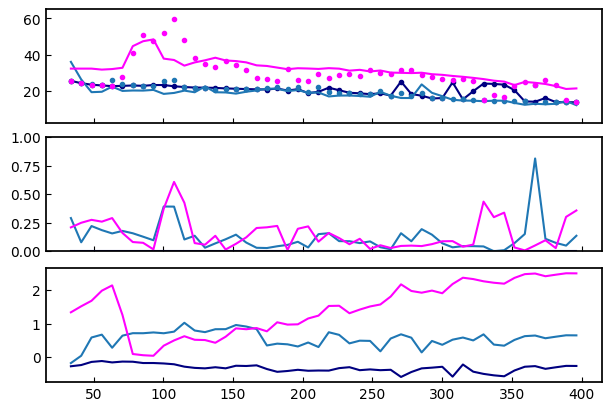

In [550]:
mods = ['2a','2b','2c']

for dn in mods:
    run1 = mods_nak[dn]
    run2 = mods_env[dn]
    run1.co = model_Tstruct(run1,layers)
    run2.co = model_Tstruct(run2,layers)
    plot_fit(run1)
    plot_fit(run2)

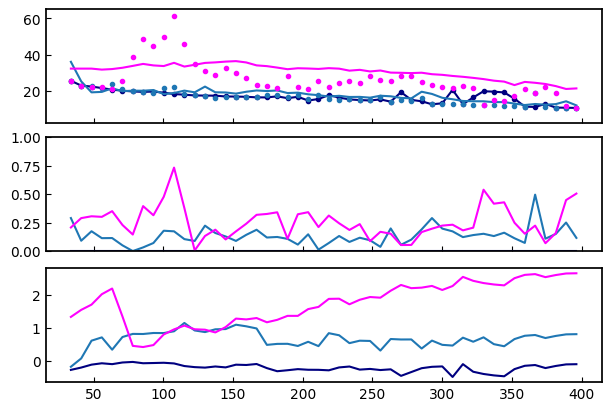

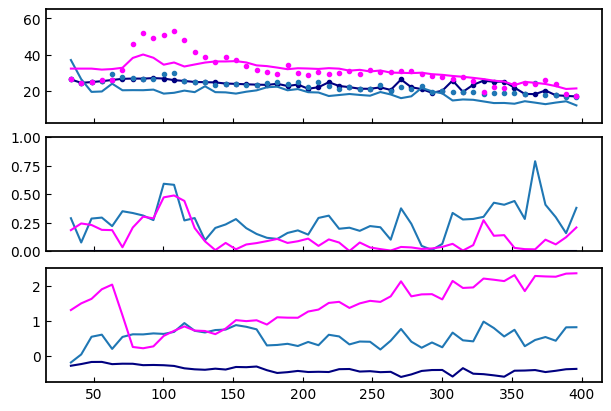

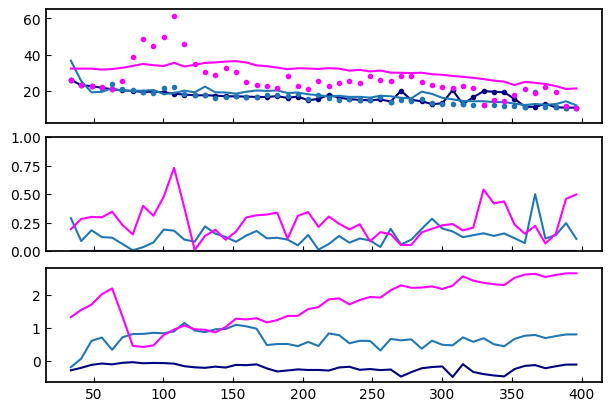

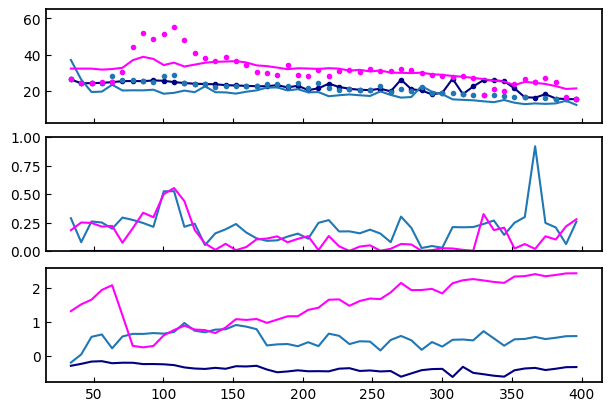

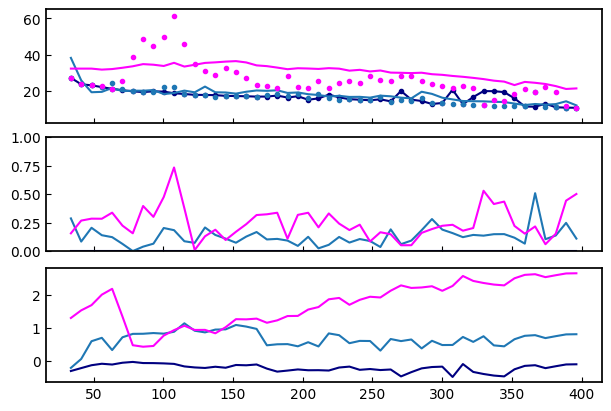

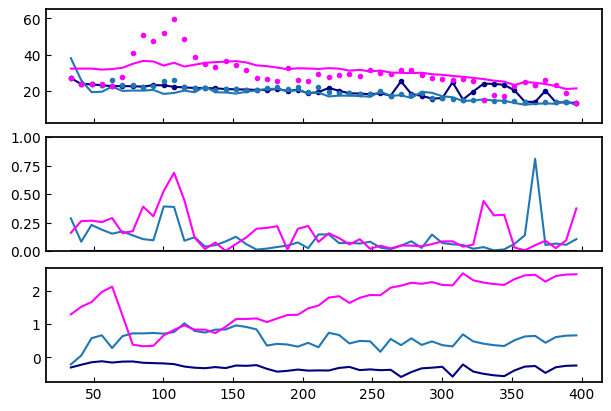

In [551]:
mods = ['1a','1b','1c']

for dn in mods:
    run1 = mods_nak[dn]
    run2 = mods_env[dn]
    run1.co = model_Tstruct(run1,layers)
    run2.co = model_Tstruct(run2,layers)
    plot_fit(run1)
    plot_fit(run2)

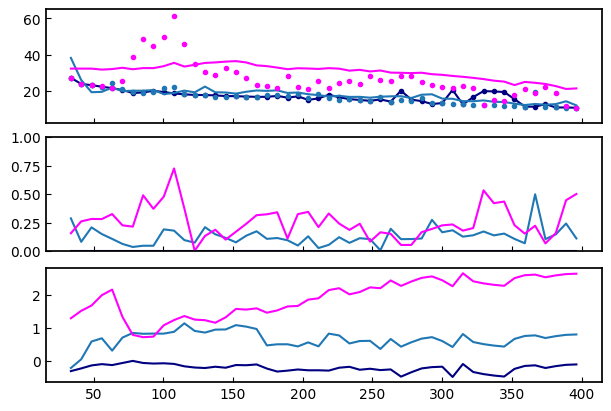

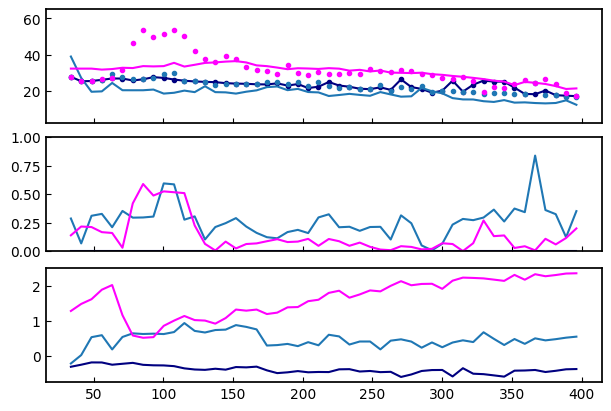

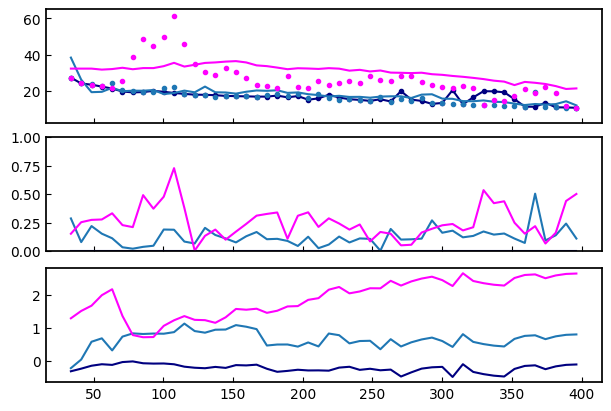

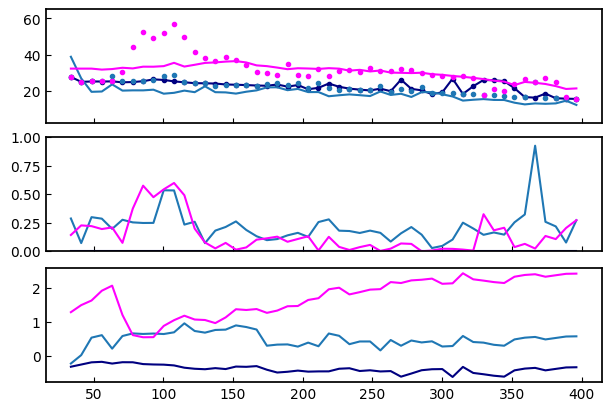

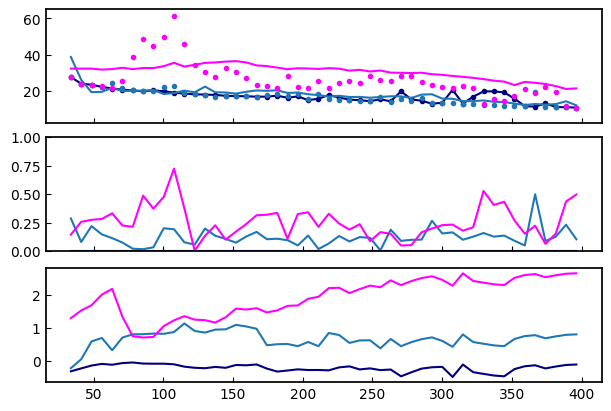

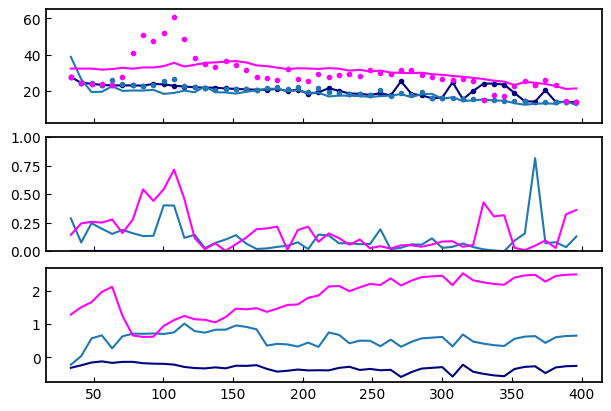

In [552]:
mods = ['05a','05b','05c']

for dn in mods:
    run1 = mods_nak[dn]
    run2 = mods_env[dn]
    run1.co = model_Tstruct(run1,layers)
    run2.co = model_Tstruct(run2,layers)
    plot_fit(run1)
    plot_fit(run2)

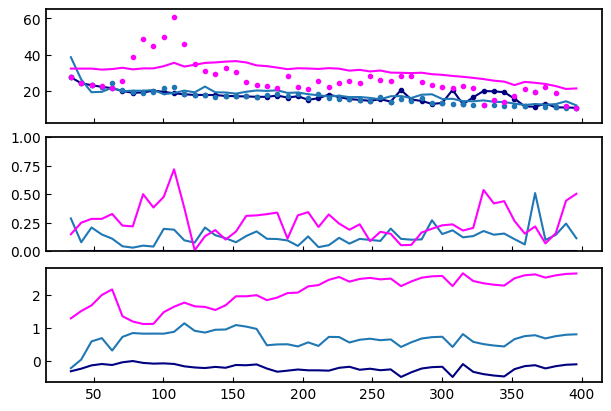

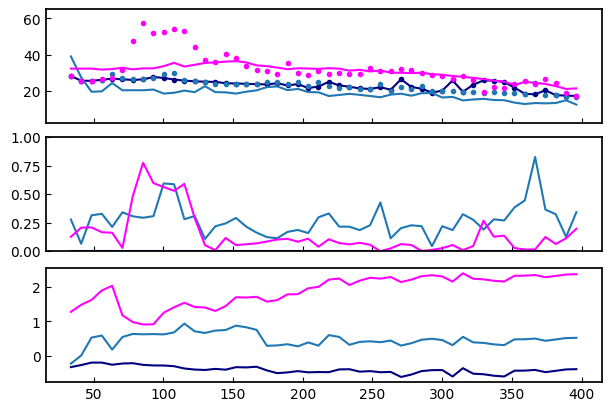

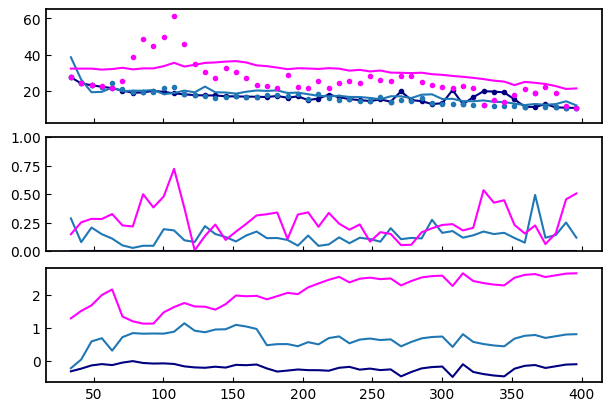

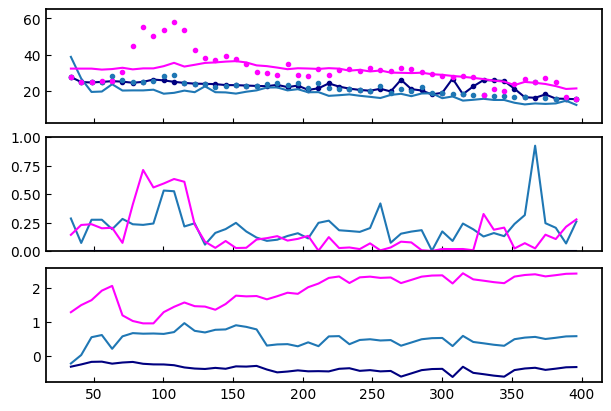

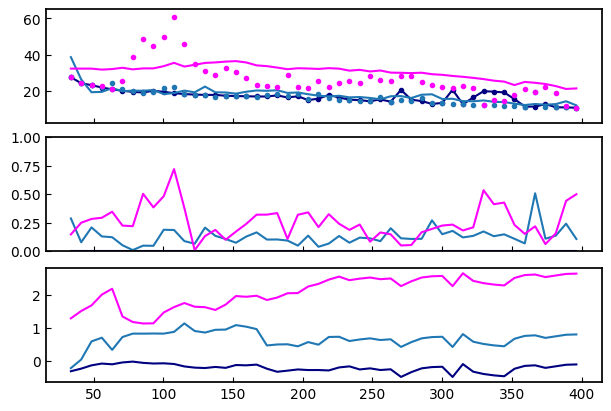

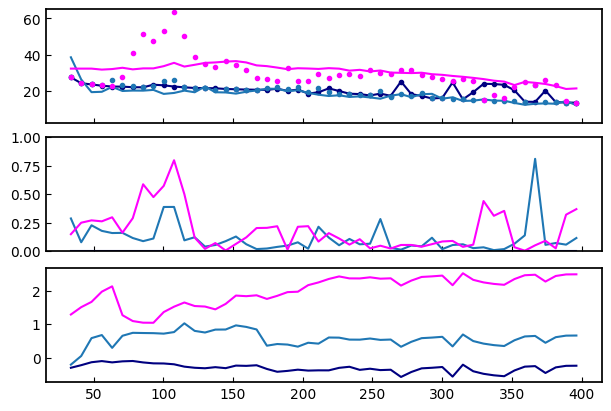

In [553]:
mods = ['02a','02b','02c']

for dn in mods:
    run1 = mods_nak[dn]
    run2 = mods_env[dn]
    run1.co = model_Tstruct(run1,layers)
    run2.co = model_Tstruct(run2,layers)
    plot_fit(run1)
    plot_fit(run2)

In [390]:
from scipy import interpolate
def smooth(rarr,arr,kind='quadratic'):
    return interpolate.interp1d(rarr[arr>0], arr[arr>0],kind=kind,fill_value='extrapolate')

In [ ]:
def layer_iter(co_layer,ll,tau_fac=np.ones_like(rbin),othin=False):
        for pt in np.arange(0,nr):
            rval = rbin[pt]
            rloc = np.where((ll['rau']>rbin_e[pt])&(ll['rau']<rbin_e[pt+1]))
            nbin = rloc[0].size
            if nbin < 1:
                pass
            else:
                rbb = ll['rau'][rloc]
                zbb = ll['zau'][rloc]
                Tbb = ll['T'][rloc]
                Tave = np.zeros(nbin)
                Tsig = np.zeros(nbin)
                tau = np.zeros(nbin)
                tau_max = np.zeros(nbin)
                Ncol = np.zeros(nbin)
                Ncol_var = np.zeros(nbin)
                Tb_est = np.zeros(nbin)
                for rb,zb,Tb,j in zip(rbb,zbb,Tbb,np.arange(nbin)):
                    rerr = 0.01
                    index = extract_column(rcyl,zcyl,rb,zb,rerr=rerr)
                    while index[0].size < 4:
                        rerr += 0.01
                        index = extract_column(rcyl,zcyl,rb,zb,rerr=rerr)
                    ncol = nH[index]
                    rvals = rcyl[index]
                    zvals = zcyl[index]
                    Tvals = Tg[index]
                    Tcrit = 130*(ncol/1e10)**(0.3)
                    ncol[(Tvals < 21) & (Tvals/Tcrit < 1.)] *= 8e-5
                    zsort = np.argsort(zvals)
                    Tvar = np.std(Tg3,axis=-1)[index]
                    Tave[j] = np.average(Tvals,weights=1./(Tvar**2))
                    Tsig[j] = np.sqrt(np.sum(Tvar**2))/np.sqrt(len(Tvar))
                    tau_max[j] = calc_tau(20,Tb)
                    Ncol[j] = np.trapz(ncol[zsort],x=zvals[zsort]*AU)
                    Ncol_max = np.trapz(nH[index][zsort]+nH_var[index][zsort],x=zvals[zsort]*AU)
                    Ncol_min = np.clip(np.trapz(nH[index][zsort]-nH_var[index][zsort],x=zvals[zsort]*AU),a_min=0,a_max=None)
                    Ncol_var[j] = (Ncol_max-Ncol_min)/2.
                    if othin == False:
                        tau[j] = Ncol[j]*tau_fac[pt]*ll['dfac']
                        tau_cum = np.append([0],integrate.cumtrapz(ncol[zsort]*ll['dfac']*tau_fac[pt], x = zvals[zsort]*AU))
                        Tb_est[j] = np.exp(-tau[j])*np.trapz(np.exp(tau_cum)*Tvals[zsort],x=tau_cum)
                        if np.isnan(Tb_est[j]):
                            Tb_est[j] = np.average(Tvals,weights=tau_cum)
                    else:
                        tau[j] = calc_tau(Tave[j],Tb)
                        A = tau[j]/Ncol[j]
                        tau_cum = np.append([0],integrate.cumtrapz(ncol[zsort]*ll['dfac']*A, x = zvals[zsort]*AU))
                        Tb_est[j] = np.exp(-tau[j])*np.trapz(np.exp(tau_cum)*Tvals[zsort],x=tau_cum)
                co_layer['Ts'][pt] = np.average(Tave,weights=1/(Tsig**2))
                co_layer['Ts_sig'][pt] = np.sqrt(np.sum(Tsig**2))/np.sqrt(len(Tsig))
                co_layer['tau'][pt] = np.average(tau)
                co_layer['tau_sig'][pt] = np.std(tau)
                co_layer['tau_max'][pt] = np.average(tau_max)
                co_layer['Ncol'][pt] = np.average(Ncol,weights=1./(Ncol_var**2))
                co_layer['Ncol_sig'][pt] = np.sqrt(np.sum(Ncol_var**2))/np.sqrt(len(Ncol_var))
                co_layer['Tb_calc'][pt] = np.average(Tb_est)
                co_layer['Tb_calc_sig'][pt] =  np.std(Tb_est)
                co_layer['Ts_m'][pt] = np.average(Tbb)/(1.-np.exp(-co_layer['tau'][pt]))
                co_layer['Ts_c'][pt] = np.average(Tb_est/(1.-np.exp(-tau)))
                co_layer['Ts_m_sig'][pt] =  np.std(Tbb)/(1.-np.exp(-co_layer['tau'][pt]))
                co_layer['Ts_c_sig'][pt] =  np.std(Tb_est/(1.-np.exp(-tau)))
                
        return co_layer


In [904]:
def get_temp_zr(run,zr=0.35):
    R,Z = run.m.make_rz()
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    Hval = run.m.H(run.m.r,fluid=0)
    theta_index = np.argmin(np.abs(np.arctan(1./zr)-run.m.theta))
    if run.T == {}:
        run.T2D()
    Tdvals = run.T['dust'].T
    Tgvals = np.average(run.Tgas3,axis=-1)
    Td = np.mean(Tdvals[theta_index-2:theta_index+2,:],axis=0)
    Tg = np.mean(Tgvals[theta_index-2:theta_index+2,:],axis=0)
    return rcyl[theta_index,:],Td,Tg

def get_temp_z(run,rval):
    R,Z = run.m.make_rz()
    #run.J = {}
    #calc_Tgas(run,ndim=3)
    rcyl = R[:,:,0]
    zcyl = Z[:,:,0]
    Tdvals = run.calc_T2D('dust').T
    Tgvals = run.calc_T2D('gas').T
    rindex = np.argmin(np.abs(rcyl-rval),axis=-1)
    zindex = np.arange(len(run.m.theta))
    Td = np.array([Tdvals[i,rj] for i,rj in zip(zindex,rindex)])
    Tg = np.array([Tgvals[i,rj] for i,rj in zip(zindex,rindex)])
    zvals = np.array([zcyl[i,rj] for i,rj in zip(zindex,rindex)])
    return zvals, Td, Tg

    



In [815]:
def get_Trz(output,r,z,temp_arr):
    r_cyl,z_cyl = output.m.make_rz()
    Trz = np.array([])
    for rp, zp in zip(r,z):
        ir = np.argmin(np.abs(r_cyl[-1,:,0] - rp))
        iz = np.argmin(np.abs(z_cyl[-1,:,0] - zp))
        ttemp = temp_arr[:iz,ir]
        temp = np.average(ttemp)
        Trz = np.append(Trz,temp)
    return Trz
    

In [819]:
def get_Trz(output,r,z,temp_arr):
    model = output.m
    R_CYL,Z_CYL = model.make_rz()
    R = R_CYL[:,:,0]
    Z = Z_CYL[:,:,0]
    Trz_func = interpolate.griddata(points=(R.flatten(),Z.flatten()),values=temp_arr.flatten(), xi = (r,z),method='nearest')
    return Trz_func


Text(0.5, 0.98, 'Midplane Dust Density Amplitude')

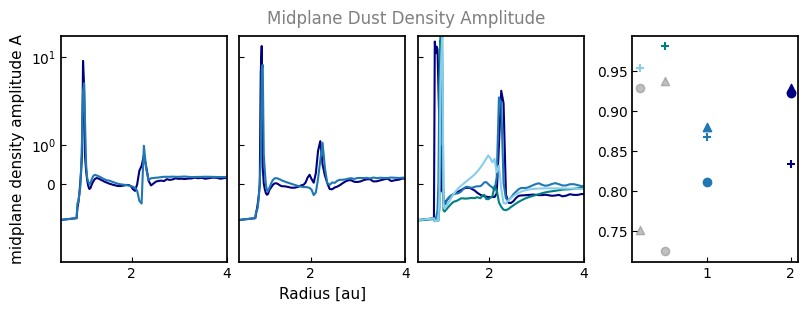

In [1741]:
m_d = ['2','1','05','02']
m_in = ['a','b','c']
min_d = {'a':1e-6,'b':5e-7,'c':1e-7}
ls = {'a':'solid','b':'dashed','c':'dotted'}
m = {'a':'o','b':'^','c':'+'}
lw = {'2': 2, '1': 1, '05':0.5, '02': 0.2}
colors = {'2':'navy','1':'C0','02':'skyblue','05':'teal'}
diff_runs = ['02a','02b','05a','05b']
f,ax = subplots(1,4,constrained_layout=True,dpi=100)
f.set_size_inches(8,3)
for infall,a in zip(m_in,ax):
    for diskmass in m_d:
        run = mods_env[diskmass + infall]
        rho_mid = np.average(run.m.rho_disk(fluid=2)[-1,:,:],axis=-1)
        pl0 = run.m.rho_midplane(run.m.r,fluid=2)
        A = rho_mid/pl0 - 1.
        A40 = np.amax(A[run.m.r < 50])
        A80 = np.amax(A[run.m.r > 50]) #- np.amin(A[(run.m.r > 40) & (run.m.r < 80)])
        if diskmass+infall not in diff_runs:
            a.plot(run.m.r/40,A,color=colors[diskmass],label=min_d[infall])
            ax[-1].scatter((lw[diskmass]),A40/(A40+A80),color=colors[diskmass],marker=m[infall])
        else:
            ax[-1].scatter((lw[diskmass]),A40/(A40+A80),color='gray',marker=m[infall],alpha=0.5)
        #ax[-1].scatter((lw[diskmass]),A40,color=colors[diskmass],marker=m[infall])
        #ax[-1].scatter((lw[diskmass]),A80,color=colors[diskmass],marker=m[infall],alpha=0.5)
        a.set_xlim(0.5,4)
    #a.set_yscale('symlog',linthresh=0.25)
        a.set_ylim(-2,20)
        a.set_yscale('symlog')
    #a.xaxis.set_major_locator(MultipleLocator(80))
    #a.xaxis.set_minor_locator(MultipleLocator(20))
        if a != ax[0]:
            a.yaxis.set_major_formatter(NullFormatter())
#ax[0].legend(title='$M_{in} \ \mathrm{[M_{\odot} \ yr^{-1}]}$')
ax[0].set_ylabel('midplane density amplitude A')
ax[1].set_xlabel('Radius [au]')
#ax[-1].set_ylim(0,1)
f.suptitle('Midplane Dust Density Amplitude',color='gray',fontsize=12)


In [755]:
def ax_set(ax,col=True,**pm):
    for a in ax:
        if col == True:
            if a != ax[-1]:
                a.xaxis.set_major_formatter(NullFormatter())
        else:
            if a != ax[0]:
                a.yaxis.set_major_formatter(NullFormatter())
        if 'ylim' in pm.keys():
            a.set_ylim(*pm['ylim'])
            if 'ny' in pm.keys():
                nyticks = pm['ny']
                ydist = pm['ylim'][1] - pm['ylim'][0]
                dy = int(ydist/nyticks)
                a.yaxis.set_major_locator(MultipleLocator(dy))
                a.yaxis.set_minor_locator(MultipleLocator(int(dy/2)))
        if 'xlim' in pm.keys():
            a.set_xlim(*pm['xlim'])
            if 'nx' in pm.keys():
                nyticks = pm['nx']
                ydist = pm['xlim'][1] - pm['xlim'][0]
                dy = int(ydist/nyticks)
                a.xaxis.set_major_locator(MultipleLocator(dy))
                a.xaxis.set_minor_locator(MultipleLocator(int(dy/2)))                       
        if col == True:
            if 'ylab' in pm.keys():
                a.set_ylabel(pm['ylab'])
        else:
            if 'xlab' in pm.keys():
                a.set_xlabel(pm['xlab'])
    if col == True:
        if 'xlab' in pm.keys():
            ax[-1].set_xlabel(pm['xlab'])
    else:
        if 'ylab' in pm.keys():
            ax[0].set_ylabel(pm['ylab'])
            

In [793]:
from scipy.stats import binned_statistic

In [1084]:
from scipy.optimize import root_scalar

In [714]:
def emission_surface(R,**params):
    zsurf = params['z0']*np.exp(-(R/params['taper'])**params['psi'])*((R/params['r0'])**params['phi'])
    return zsurf

dpc = 159
conv_fac = (dpc*pc)/(AU*206265)
COparams = {'z0':0.385*conv_fac, 'phi':1.066, 'taper': 3.767*conv_fac, 'psi':4.988, 'r0': conv_fac,
           'T100':52, 'q': 0.61}
C13Oparams = {'z0':0.113*conv_fac, 'phi':4.539, 'taper': 1.496*conv_fac, 'psi':4.989,'r0':conv_fac,
             'T100':22, 'q': 0.26}
CO18params = {'z0':0.95*conv_fac, 'phi':3.556, 'taper': 0.402*conv_fac, 'psi':3.766, 'r0': conv_fac,
             'T100':14, 'q': 0.38}


def T_fit(R, **params):
    T_fit = params['T100']*(R/100.)**(-params['q'])
    return T_fit

In [ ]:
z13c = emission_surface(m0.r,**C13Oparams)
T13c = {}
for models in [m0,m5,m6,m7,m8]:
    runname = models.m.outdir.split('/gmaur/')[-1].strip('/')
    T13c[runname] = get_Trz(models, r=models.r, z=z13c)

In [55]:
z18o = emission_surface(m0.r,**COparams)
T18o = get_Trz(m0, r= m0.r, z=z18o,fluid='gas')



In [39]:
z12c = emission_surface(m0.r,**COparams)
T12c = {}
for models in [m0,m5,m6,m7,m8]:
    runname = models.m.outdir.split('/gmaur/')[-1].strip('/')
    T12c[runname] = get_Trz(models, r=models.r, z=z12c)

In [40]:
z18o = emission_surface(m0.r,**CO18params)
T18o = {}
for models in [m0,m5,m6,m7,m8]:
    runname = models.m.outdir.split('/gmaur/')[-1].strip('/')
    T18o[runname] = get_Trz(models, r=models.r, z=z18o)